## Host Ecosystem Analysis

This notebook analyzes Thessaloniki's short-term rental host ecosystem to understand operator types and market concentration.

### Host categorization
- **Individual:** Single-listing hosts, typically casual or occasional operators
- **Small-multi:** Hosts with 2 or 3 listings, often semi-professional operators
- **Large-multi:** Hosts with 4 or more listings, typically professional operators

### Question
Do multi-property hosts achieve different guest engagement patterns than smaller operators?
Does the current host ecosystem structure benefit the rental market?
Is there a sweet spot in host size for optimal performance?

In [32]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.insert(0, str(Path.cwd().parent))

from scripts.eda_functions import (
    analyze_numeric_variable,
    analyze_categorical_variable,
    analyze_categorical_numerical,
    analyze_categorical_categorical
    )

In [8]:
data_path = Path.cwd().parent / "data" / "processed"
df = pd.read_parquet(data_path / "listings_regular_license.parquet", engine="pyarrow")
pd.set_option('display.float_format', '{:,.2f}'.format)
df.shape

(4622, 54)

In [9]:
# Set global style and color palette
sns.set_theme(style="whitegrid")
sns.set_palette("Set2")  # or "husl", "muted", "pastel", "deep", "colorblind"

# For matplotlib defaults
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=sns.color_palette("Set2"))

In [10]:
# Host category distribution
df["Host_Category"].value_counts(normalize=True).round(2)

Host_Category
Large Multi (4+)    0.55
Individual (1)      0.23
Small Multi (2-3)   0.17
nan                 0.05
Name: proportion, dtype: float64

### Nan values imputation in `Host_Category`

In [21]:
nan_df = df.loc[df["Host_Category"] == "nan"]
nan_df.shape

(0, 54)

In [22]:
nan_df["host_id"].nunique()

0

In [23]:
# Take a look at the most frequent hosts in the nan dataset
nan_df["host_id"].value_counts().head(5)

Series([], Name: count, dtype: int64)

**Note:** There seem to be plenty of listings with missing host data for some hosts. We will try to impute these values based on the number of listings each host has.

In [24]:
# Count occurrences of each host_id from nan_df in the full df
host_counts = df.loc[df["host_id"].isin(nan_df["host_id"]), "host_id"].value_counts()

# Map counts to categories
def categorize_host(count):
    if count == 1:
        return "Individual (1)"
    elif count <= 3:
        return "Small Multi (2-3)"
    else:
        return "Large Multi (4+)"

host_category_map = host_counts.apply(categorize_host)

# Update Host_Category for these hosts
df.loc[df["host_id"].isin(nan_df["host_id"]), "Host_Category"] = df["host_id"].map(host_category_map)

In [25]:
df["Host_Category"].value_counts(normalize=True).round(2)

Host_Category
Large Multi (4+)    0.58
Individual (1)      0.24
Small Multi (2-3)   0.18
Name: proportion, dtype: float64

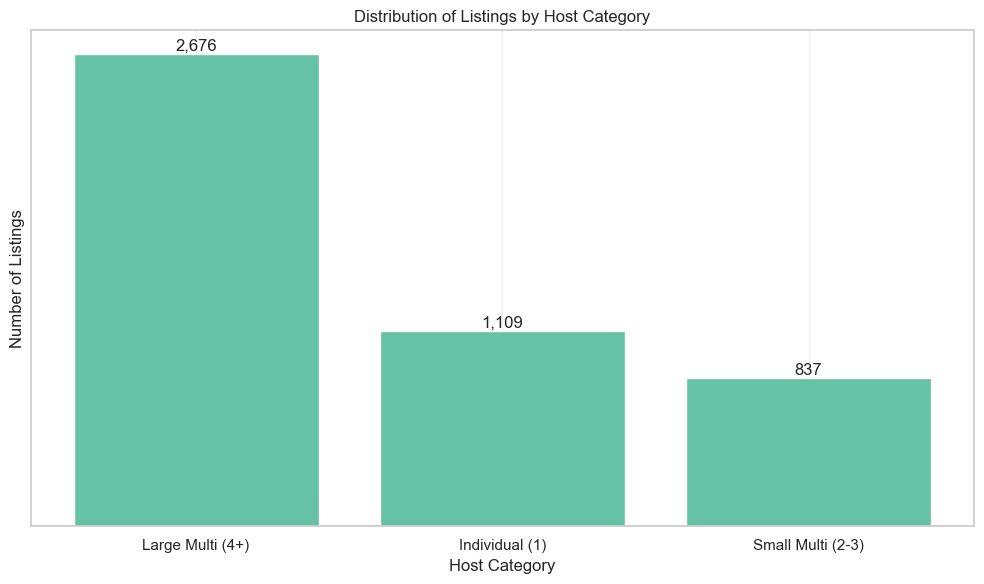

In [26]:
# Bar chart for Host Category distribution
host_category_counts = df["Host_Category"].value_counts()

plt.figure(figsize=(10, 6))
bars = plt.bar(host_category_counts.index, host_category_counts.values)
plt.xlabel('Host Category')
plt.ylabel('Number of Listings')
plt.title('Distribution of Listings by Host Category')
plt.xticks(rotation=0)

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:,}',
             ha='center', va='bottom')

ax = plt.gca()
ax.set_yticks([])
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [27]:
df["host_total_listings_count"].describe()

count   4,387.00
mean       63.60
std       139.29
min         1.00
25%         2.00
50%         5.00
75%        35.00
max     1,038.00
Name: host_total_listings_count, dtype: Float64

In [28]:
df["host_total_listings_count"].mode()

0    1
Name: host_total_listings_count, dtype: Int16

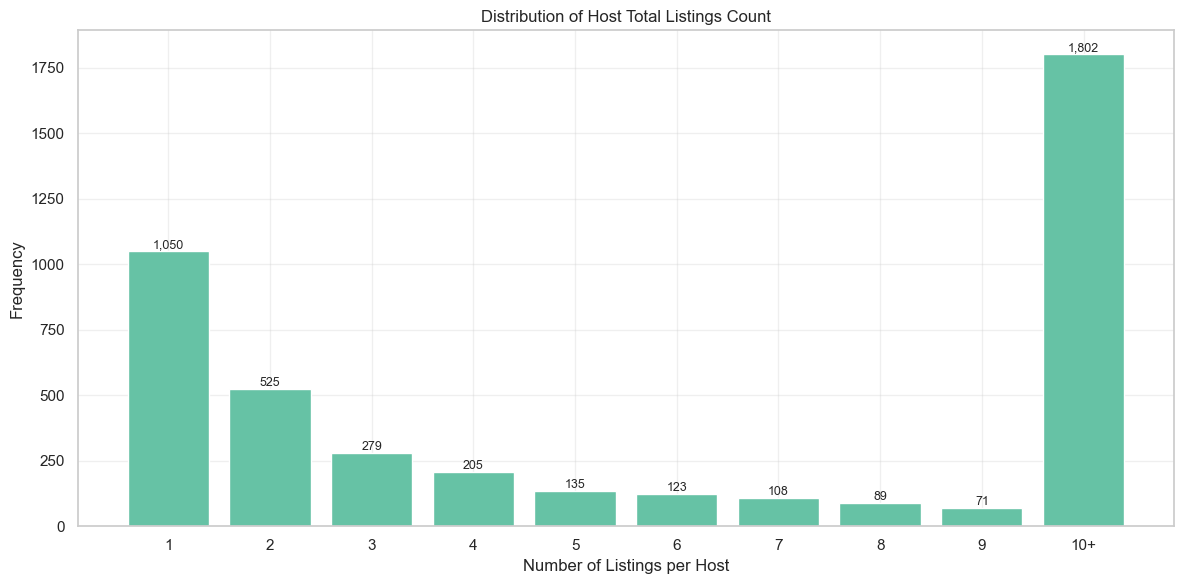

In [29]:
# Create binned histogram for host_total_listings_count
bins = list(range(1, 11)) + [df["host_total_listings_count"].max() + 1]
labels = [str(i) for i in range(1, 10)] + ["10+"]

df["listings_bin"] = pd.cut(df["host_total_listings_count"], bins=bins, labels=labels, right=False)
bin_counts = df["listings_bin"].value_counts().sort_index()

plt.figure(figsize=(12, 6))
bars = plt.bar(bin_counts.index, bin_counts.values)
plt.xlabel('Number of Listings per Host')
plt.ylabel('Frequency')
plt.title('Distribution of Host Total Listings Count')

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:,}',
             ha='center', va='bottom', fontsize=9)

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Clean up temporary column
df.drop(columns=["listings_bin"], inplace=True)

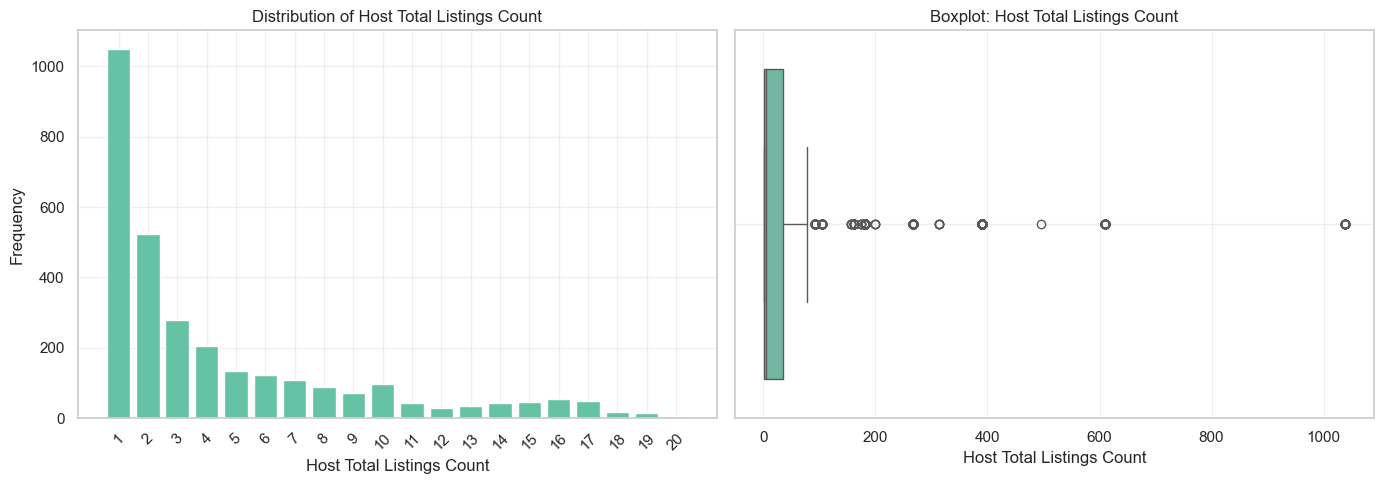

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart
listing_counts = df["host_total_listings_count"].value_counts().sort_index().head(20)
axes[0].bar(listing_counts.index.astype(str), listing_counts.values)
axes[0].set_xlabel('Host Total Listings Count')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Host Total Listings Count')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, alpha=0.3)

# Boxplot
sns.boxplot(x=df["host_total_listings_count"], ax=axes[1])
axes[1].set_xlabel('Host Total Listings Count')
axes[1].set_title('Boxplot: Host Total Listings Count')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**Comment:** The distribution of `host_total_listings_count` seems to be highly right-skewed. While most hosts have only 1 listing, there are quite a few extreme outliers with hundreds of listings.

<hr>

### Variables to check against `Host_Category`

In [34]:
df.columns

Index(['id', 'name', 'host_id', 'host_since', 'host_location',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_total_listings_count',
       'host_identity_verified', 'neighbourhood', 'neighbourhood_cleansed',
       'latitude', 'longitude', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'price', 'minimum_nights',
       'maximum_nights', 'availability_30', 'availability_60',
       'availability_90', 'availability_365', 'number_of_reviews',
       'number_of_reviews_ltm', 'availability_eoy', 'number_of_reviews_ly',
       'estimated_occupancy_l365d', 'estimated_revenue_l365d', 'first_review',
       'last_review', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'license', 'instant_bookable',
       'reviews_per_month', 'Host_Categor

In [43]:
variables = [
    "listing_age_years",
    "estimated_revenue_l365d",
    "estimated_occupancy_l365d",
    "review_scores_rating",
    "host_is_superhost"

]

In [19]:
for var in variables:
    print(df[var].dtype)

object
float64
int64
float64
object


1 -LISTING_AGE_YEARS
DESCRIPTIVE STATISTICS: listing_age_years

Central Tendency:
  Mean:           2.79
  Median:         1.89
  Mode:           0.6543463381245722

Dispersion:
  Std Dev:        2.51
  Variance:       6.32
  Range:          13.06
  IQR:            3.18

Quartiles:
  Min (0%):       0.00
  Q1 (25%):       0.82
  Q2 (50%):       1.89
  Q3 (75%):       4.01
  Max (100%):     13.06

Shape:
  Skewness:       1.068
  Kurtosis:       0.218

Sample Size:
  Valid:          4111
  Missing:        511
  Total:          4622


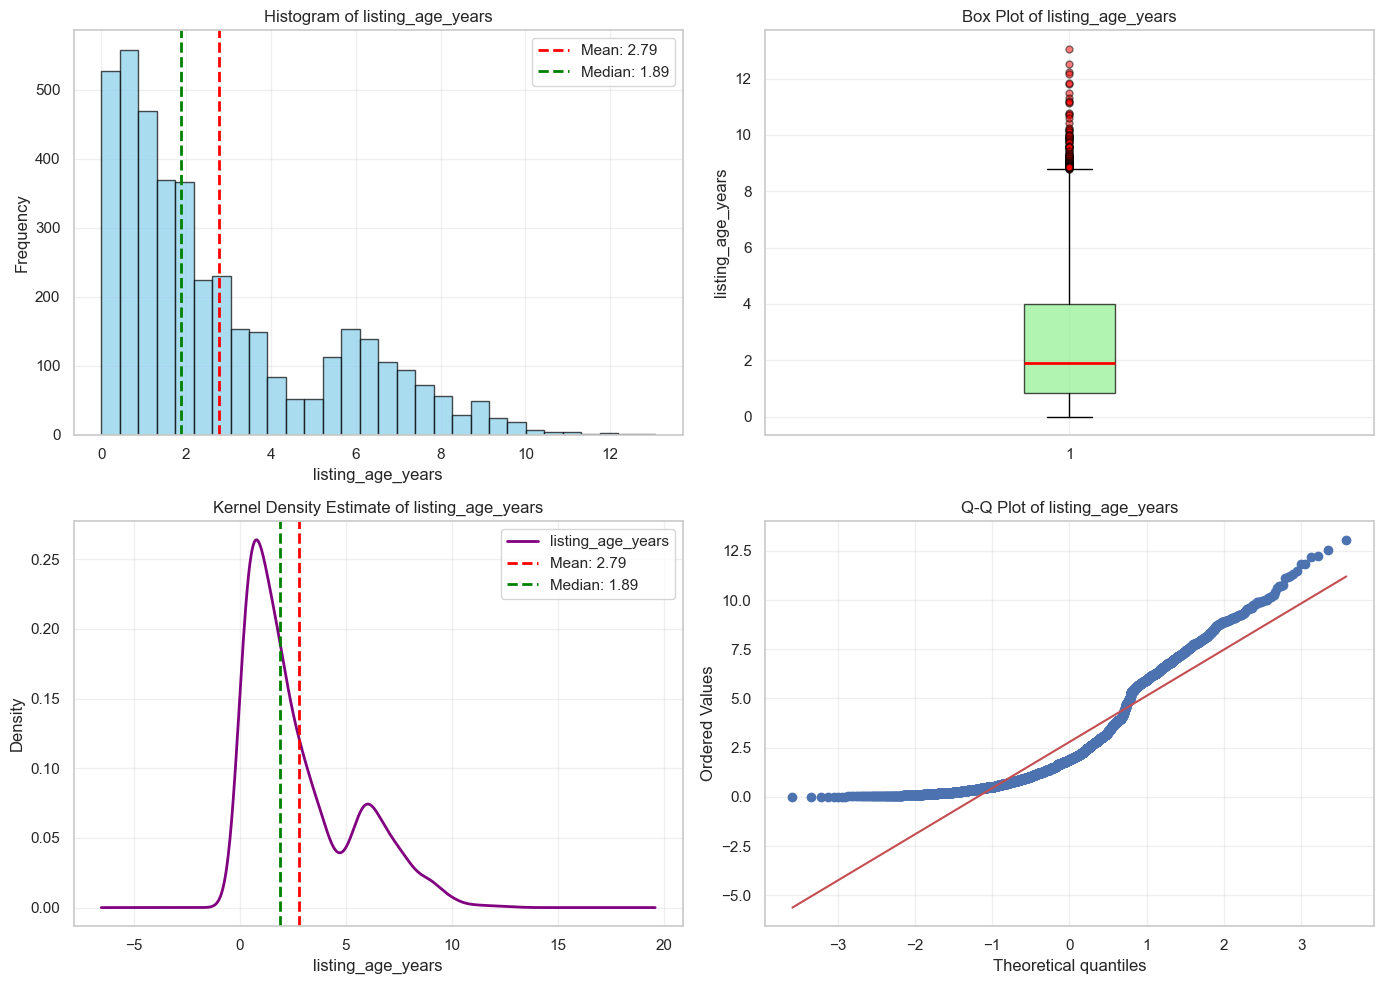

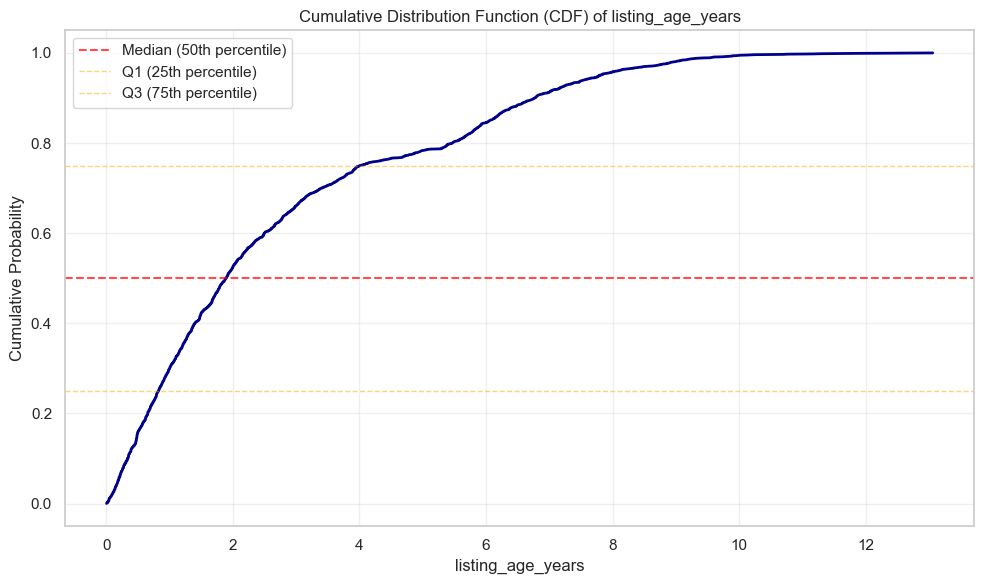

/Users/fotisn/code/repos/thess_project/airbnb-rental-market-analysis-thessaloniki/scripts/eda_functions.py:721: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


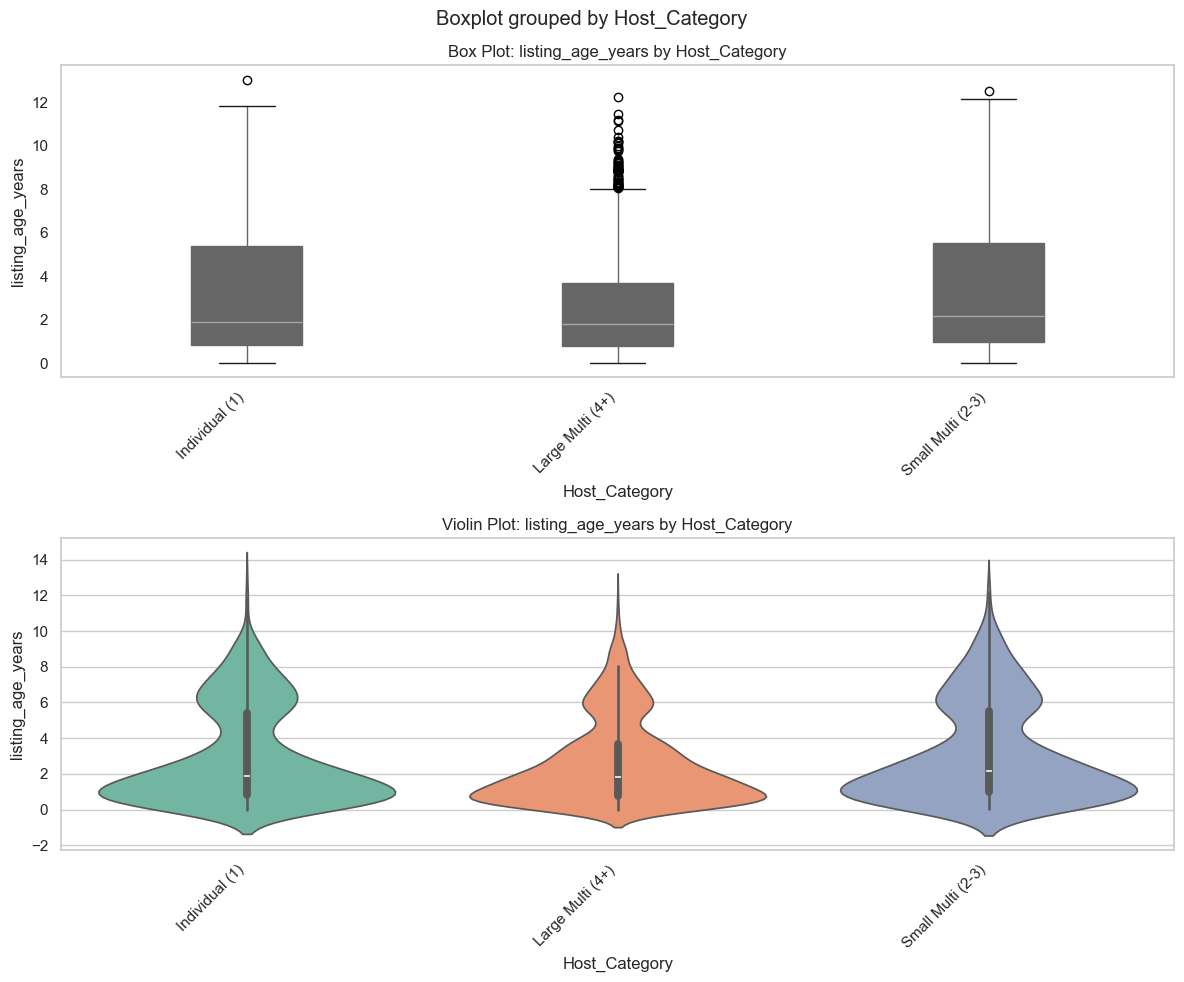

ONE-WAY ANOVA: listing_age_years by Host_Category

Descriptive Statistics by Group:

  Host_Category = Individual (1):
    N:      998
    Mean:   2.9828
    Median: 1.8864
    Std:    2.7017
    Min:    0.0027
    Max:    13.0595

  Host_Category = Large Multi (4+):
    N:      2348
    Mean:   2.5834
    Median: 1.8111
    Std:    2.3242
    Min:    0.0055
    Max:    12.2409

  Host_Category = Small Multi (2-3):
    N:      765
    Mean:   3.1567
    Median: 2.1492
    Std:    2.7492
    Min:    0.0110
    Max:    12.5175

Test Statistics:
  Test:                One-Way ANOVA
  Test statistic:      19.1659
  P-value:             0.000000
  Eta-squared (η²):    0.009
  Effect size:         Negligible effect
  Significant at α=0.05: YES

Interpretation:
  SIGNIFICANT difference detected (p=0.000000). Host_Category has a significant effect on listing_age_years. Negligible effect (Eta-squared (η²) = 0.009).

Assumption Checks:
  Normality (Shapiro-Wilk test):
    Host_Category = Individ

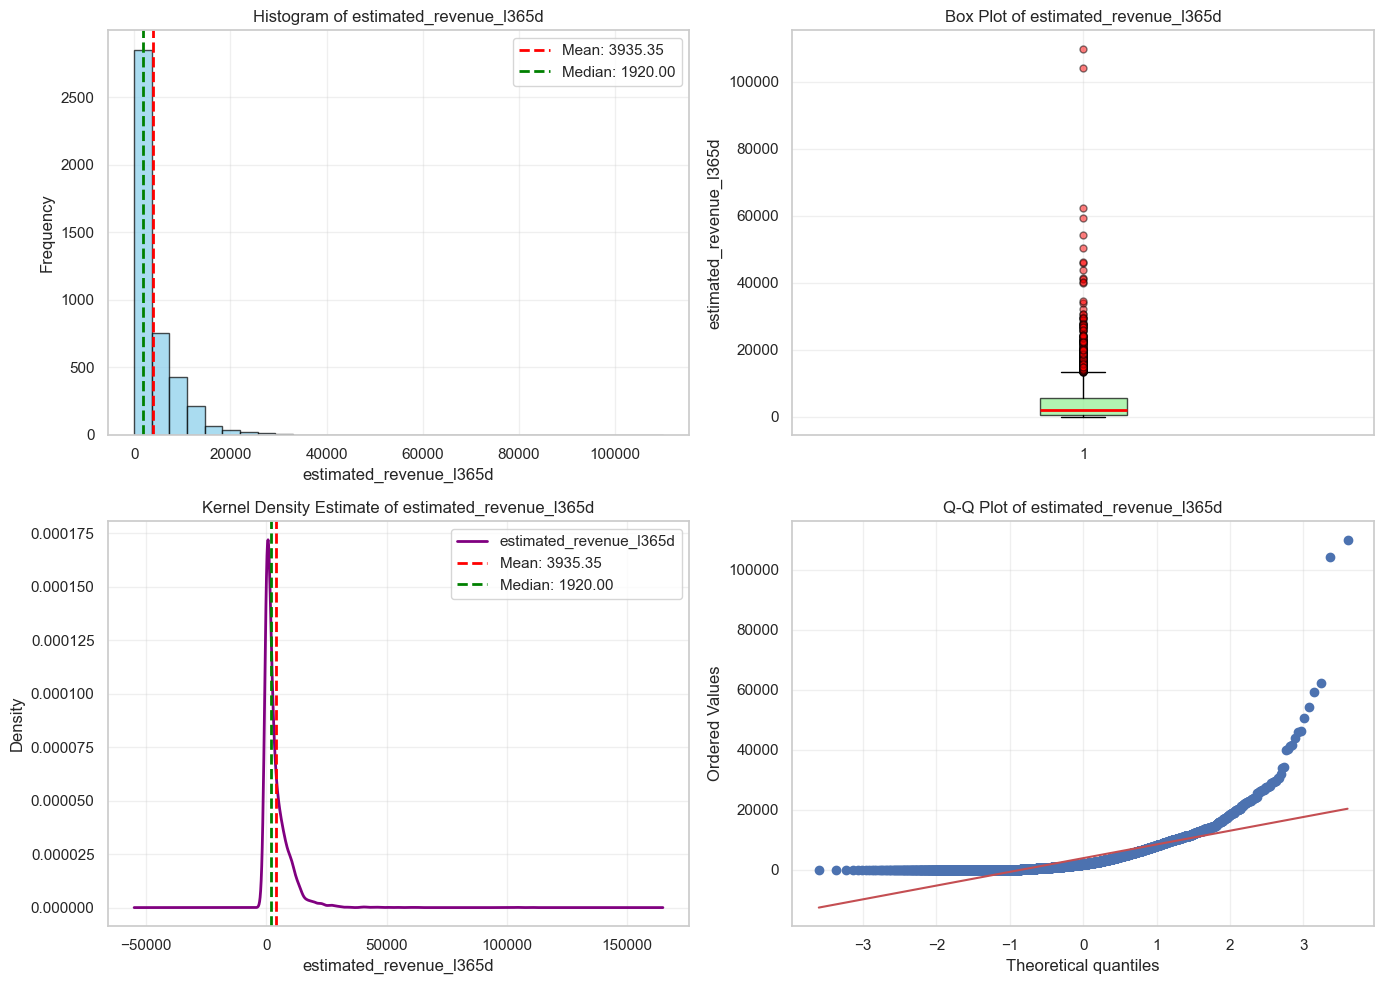

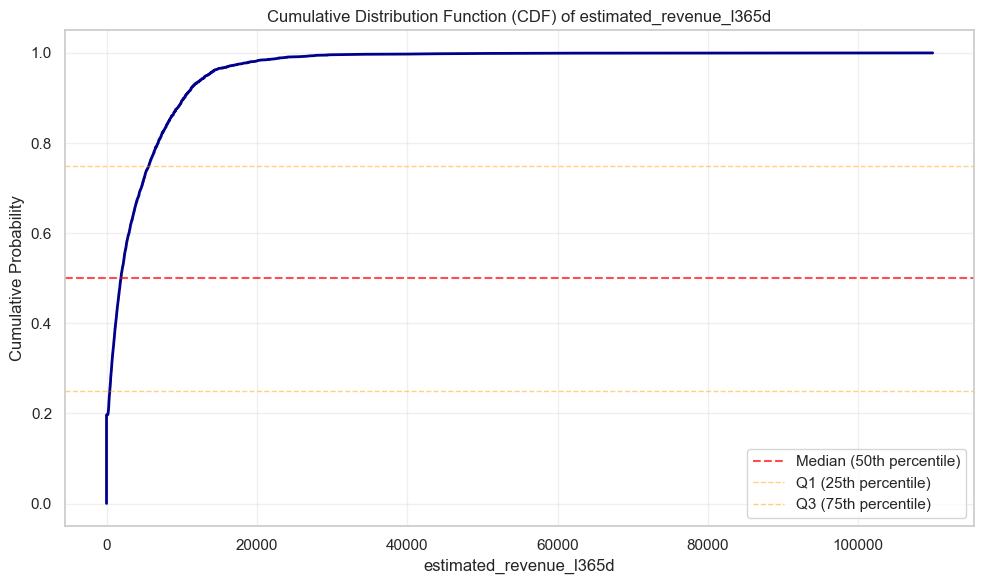

/Users/fotisn/code/repos/thess_project/airbnb-rental-market-analysis-thessaloniki/scripts/eda_functions.py:721: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


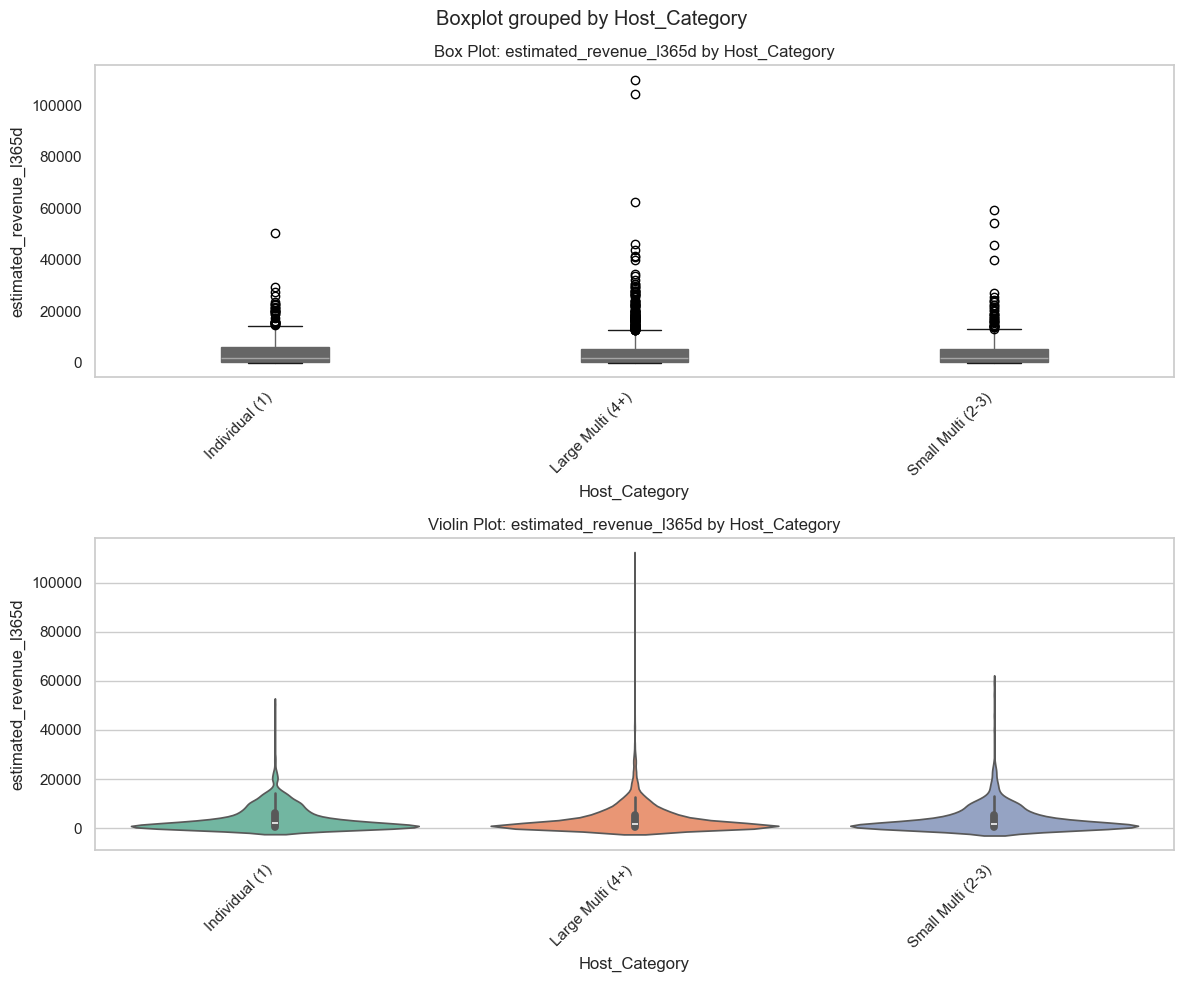

ONE-WAY ANOVA: estimated_revenue_l365d by Host_Category

Descriptive Statistics by Group:

  Host_Category = Individual (1):
    N:      1052
    Mean:   3984.8688
    Median: 2103.0000
    Std:    4887.3390
    Min:    0.0000
    Max:    50430.0000

  Host_Category = Large Multi (4+):
    N:      2555
    Mean:   3931.7750
    Median: 1872.0000
    Std:    6020.4327
    Min:    0.0000
    Max:    109896.0000

  Host_Category = Small Multi (2-3):
    N:      799
    Mean:   3881.5857
    Median: 1776.0000
    Std:    5637.1702
    Min:    0.0000
    Max:    59280.0000

Test Statistics:
  Test:                One-Way ANOVA
  Test statistic:      0.0758
  P-value:             0.927045
  Eta-squared (η²):    0.000
  Effect size:         Negligible effect
  Significant at α=0.05: NO

Interpretation:
  NO significant difference (p=0.927045). Host_Category does not significantly affect estimated_revenue_l365d.

Assumption Checks:
  Normality (Shapiro-Wilk test):
    Host_Category = Individua

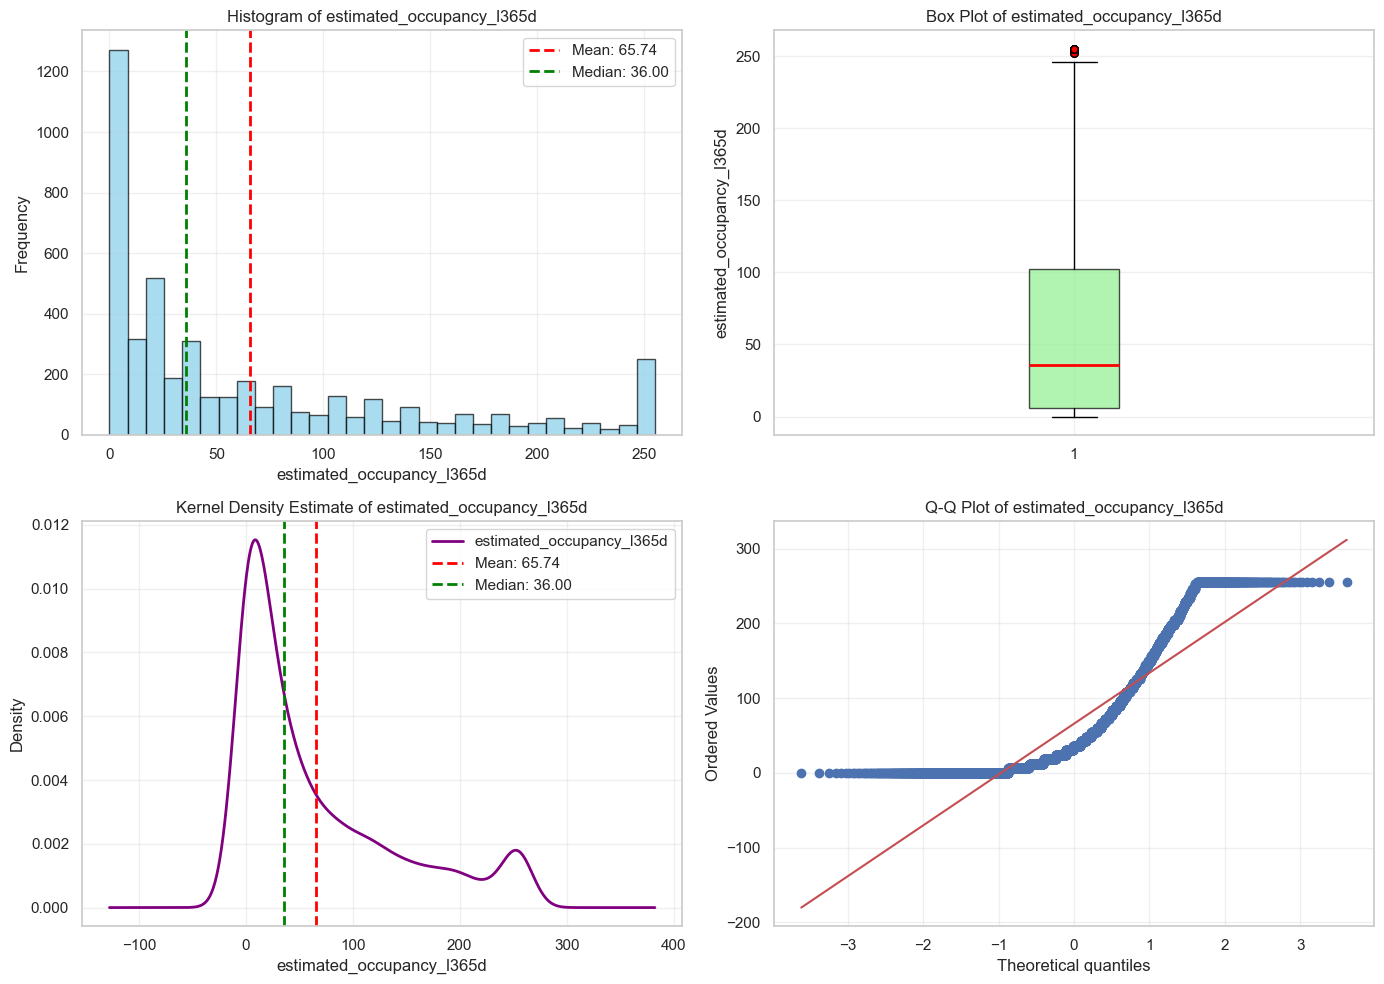

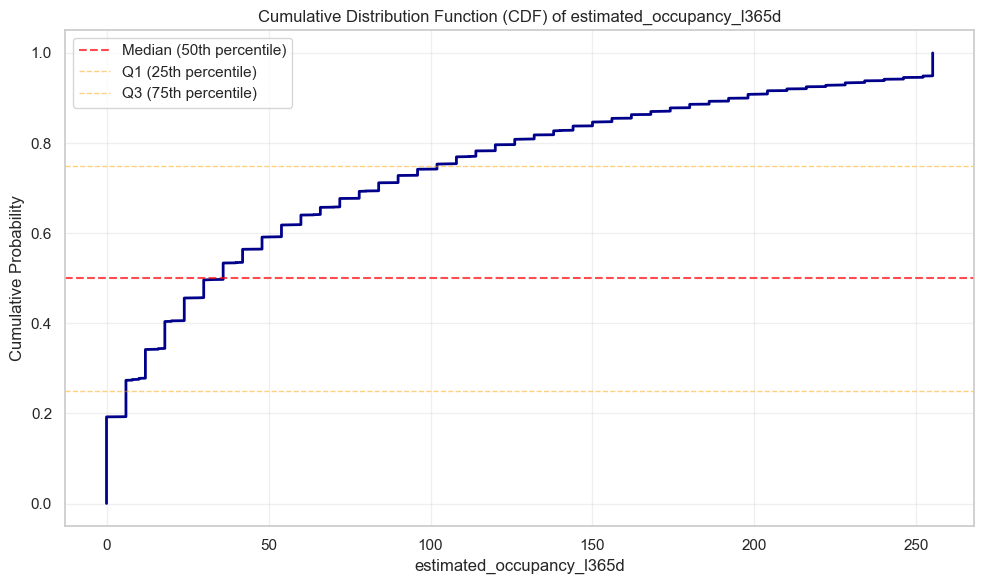

/Users/fotisn/code/repos/thess_project/airbnb-rental-market-analysis-thessaloniki/scripts/eda_functions.py:721: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


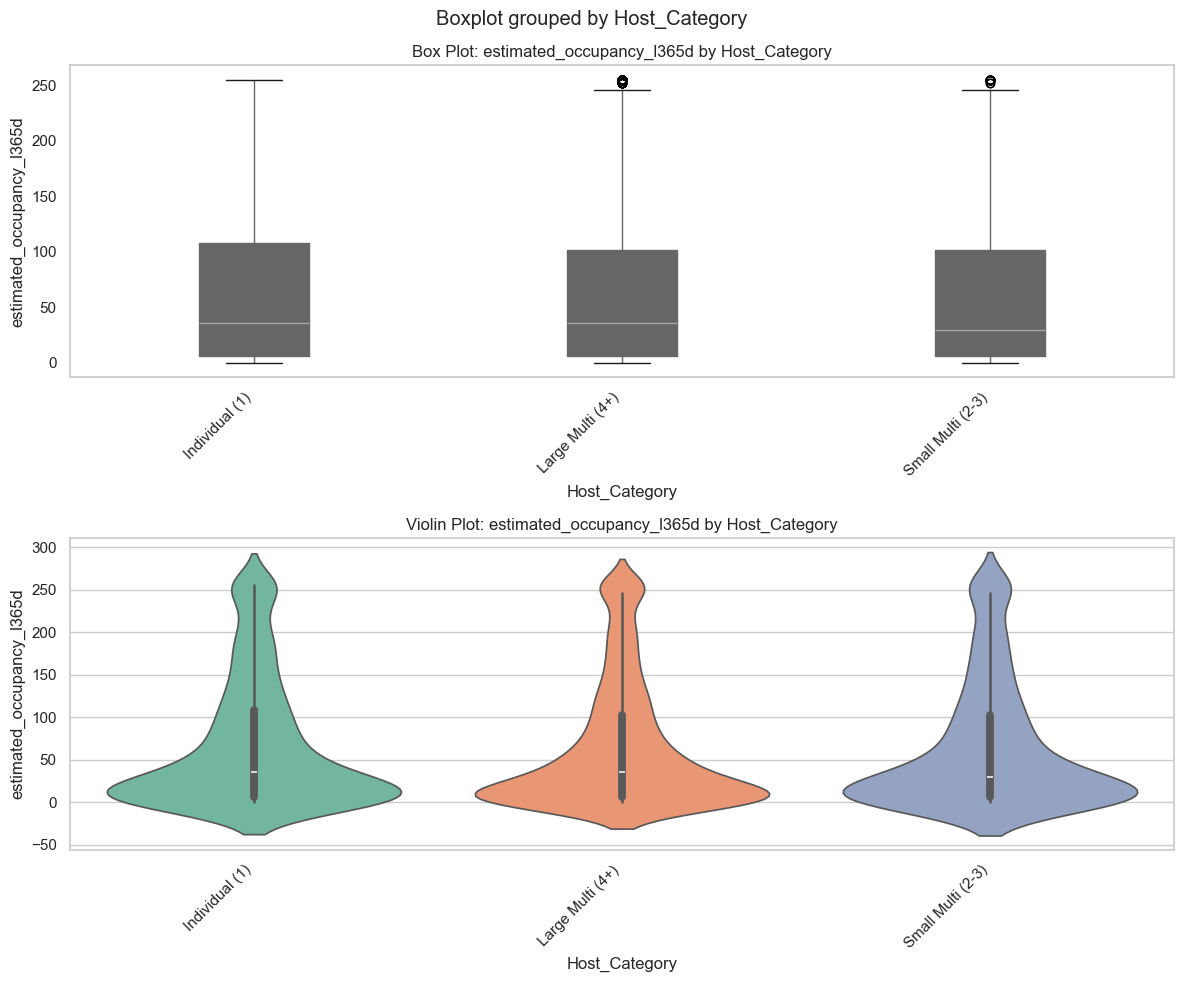

ONE-WAY ANOVA: estimated_occupancy_l365d by Host_Category

Descriptive Statistics by Group:

  Host_Category = Individual (1):
    N:      1109
    Mean:   67.9243
    Median: 36.0000
    Std:    76.5103
    Min:    0.0000
    Max:    255.0000

  Host_Category = Large Multi (4+):
    N:      2676
    Mean:   65.0437
    Median: 36.0000
    Std:    75.3698
    Min:    0.0000
    Max:    255.0000

  Host_Category = Small Multi (2-3):
    N:      837
    Mean:   65.0705
    Median: 30.0000
    Std:    75.3506
    Min:    0.0000
    Max:    255.0000

Test Statistics:
  Test:                One-Way ANOVA
  Test statistic:      0.6085
  P-value:             0.544196
  Eta-squared (η²):    0.000
  Effect size:         Negligible effect
  Significant at α=0.05: NO

Interpretation:
  NO significant difference (p=0.544196). Host_Category does not significantly affect estimated_occupancy_l365d.

Assumption Checks:
  Normality (Shapiro-Wilk test):
    Host_Category = Individual (1): p=0.0000 (Non-

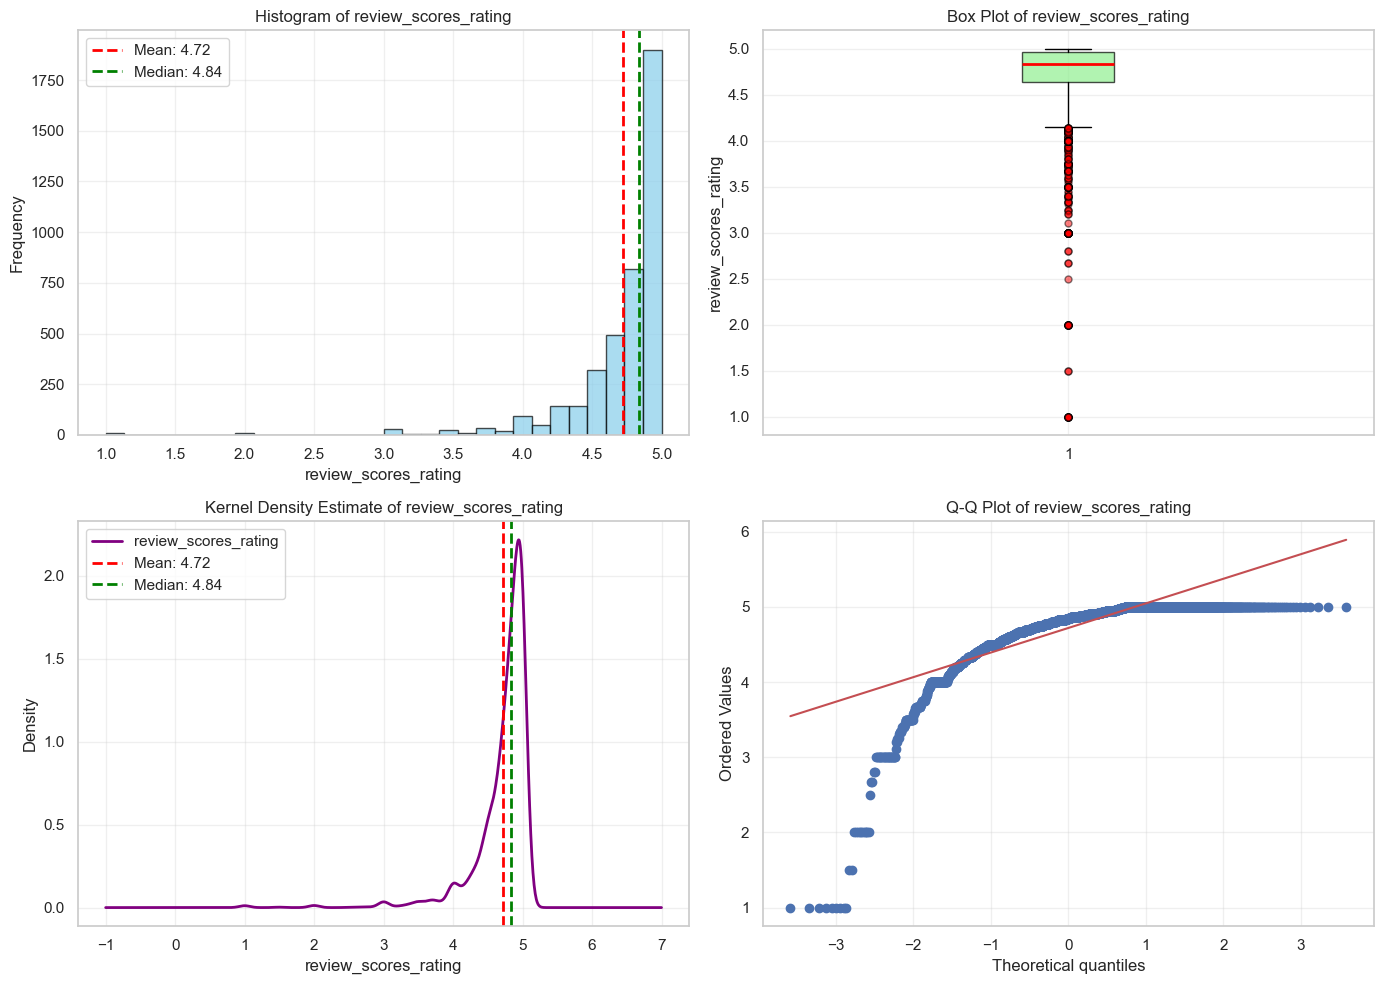

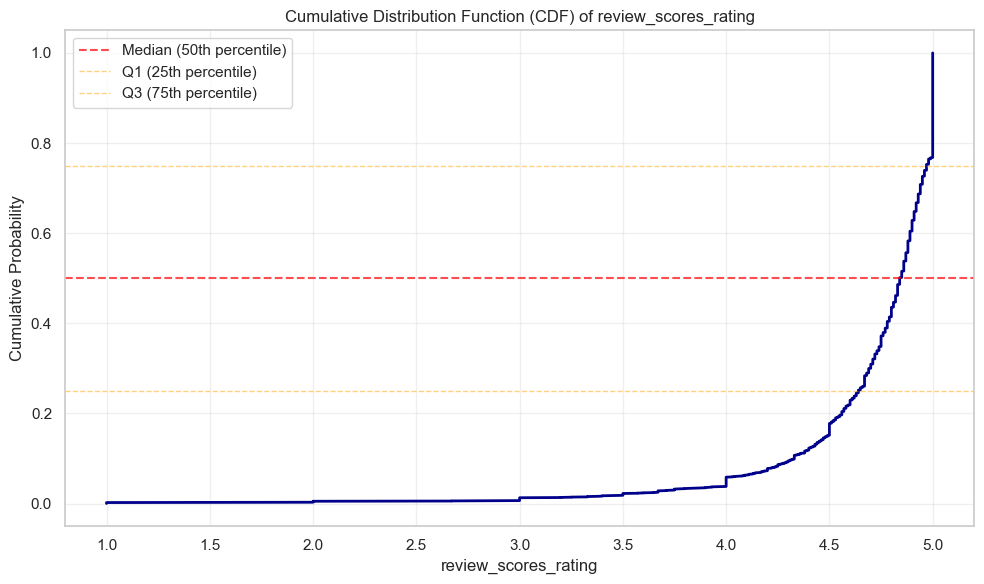

/Users/fotisn/code/repos/thess_project/airbnb-rental-market-analysis-thessaloniki/scripts/eda_functions.py:721: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


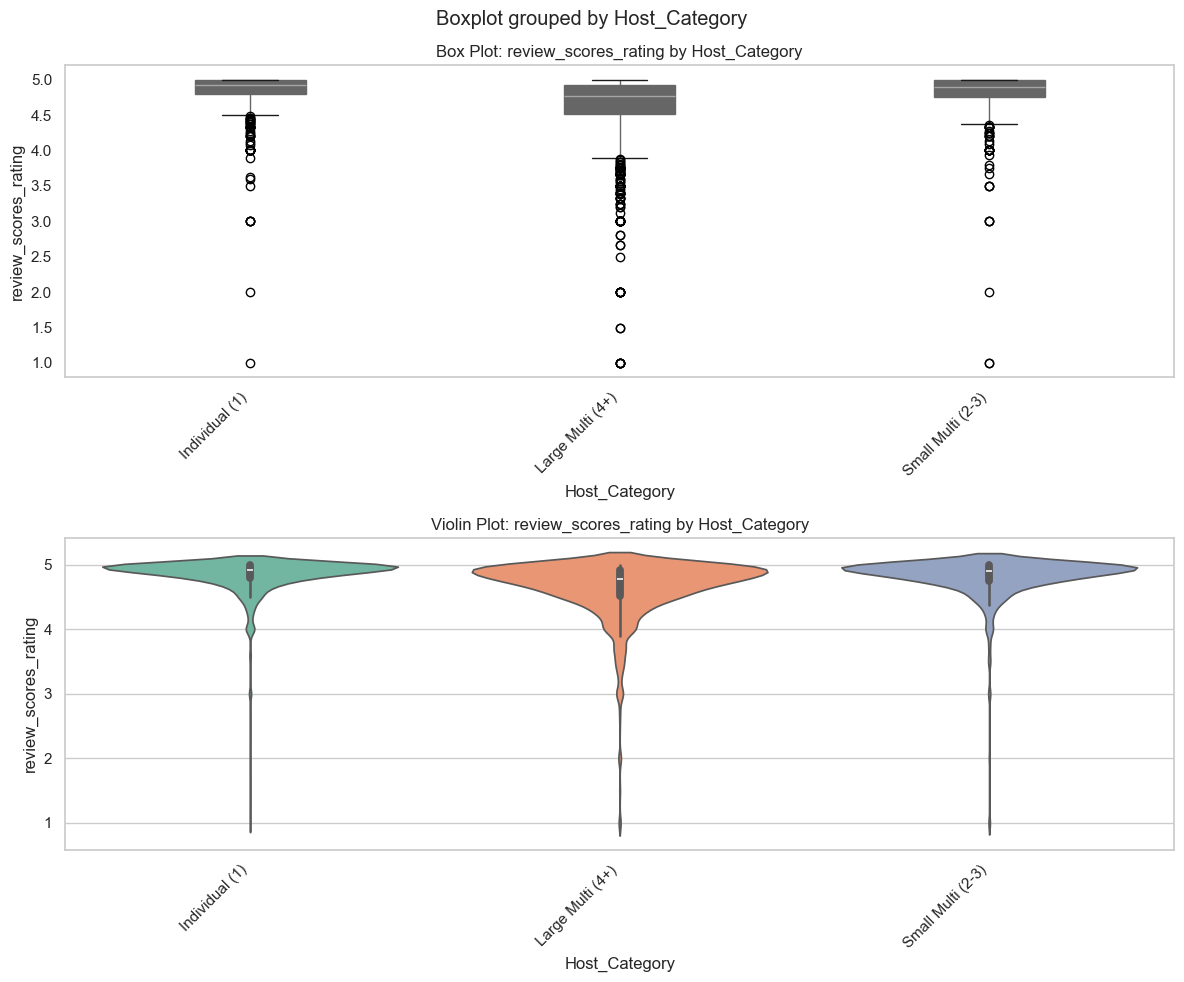

ONE-WAY ANOVA: review_scores_rating by Host_Category

Descriptive Statistics by Group:

  Host_Category = Individual (1):
    N:      998
    Mean:   4.8396
    Median: 4.9200
    Std:    0.2811
    Min:    1.0000
    Max:    5.0000

  Host_Category = Large Multi (4+):
    N:      2348
    Mean:   4.6411
    Median: 4.7700
    Std:    0.4571
    Min:    1.0000
    Max:    5.0000

  Host_Category = Small Multi (2-3):
    N:      765
    Mean:   4.8079
    Median: 4.9000
    Std:    0.3342
    Min:    1.0000
    Max:    5.0000

Test Statistics:
  Test:                One-Way ANOVA
  Test statistic:      109.1777
  P-value:             0.000000
  Eta-squared (η²):    0.050
  Effect size:         Small effect
  Significant at α=0.05: YES

Interpretation:
  SIGNIFICANT difference detected (p=0.000000). Host_Category has a significant effect on review_scores_rating. Small effect (Eta-squared (η²) = 0.050).

Assumption Checks:
  Normality (Shapiro-Wilk test):
    Host_Category = Individual (1

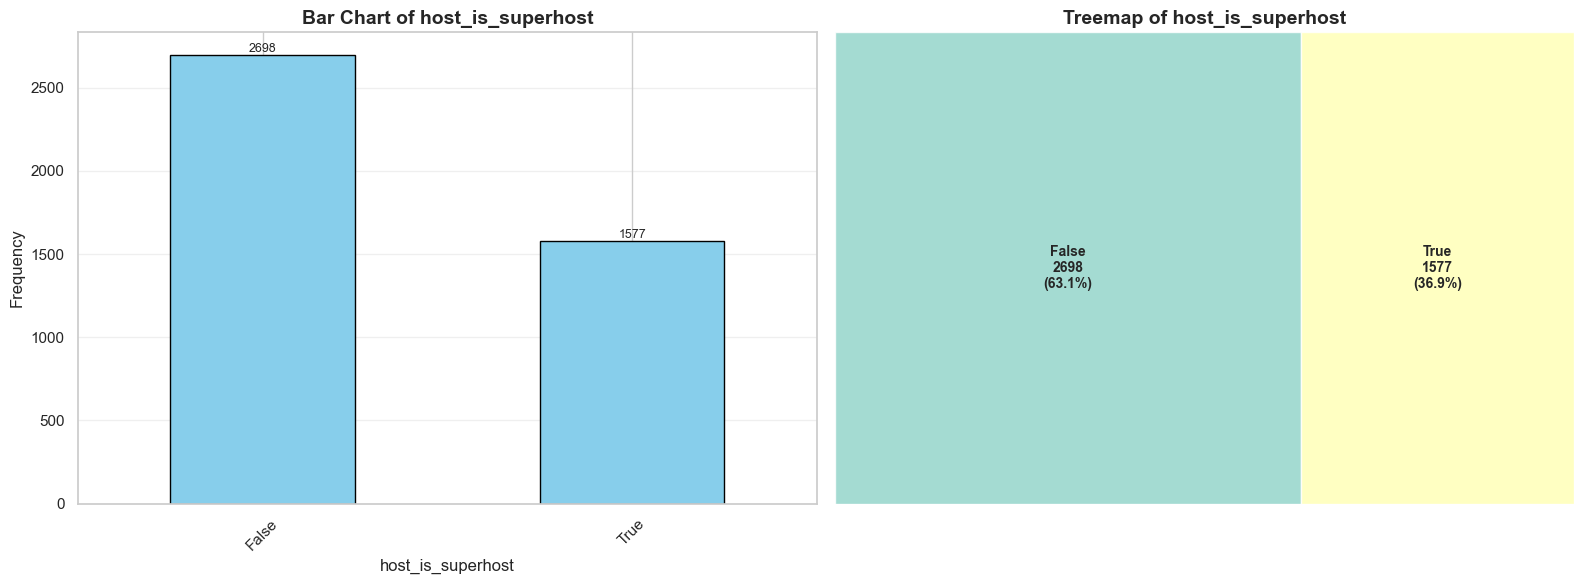

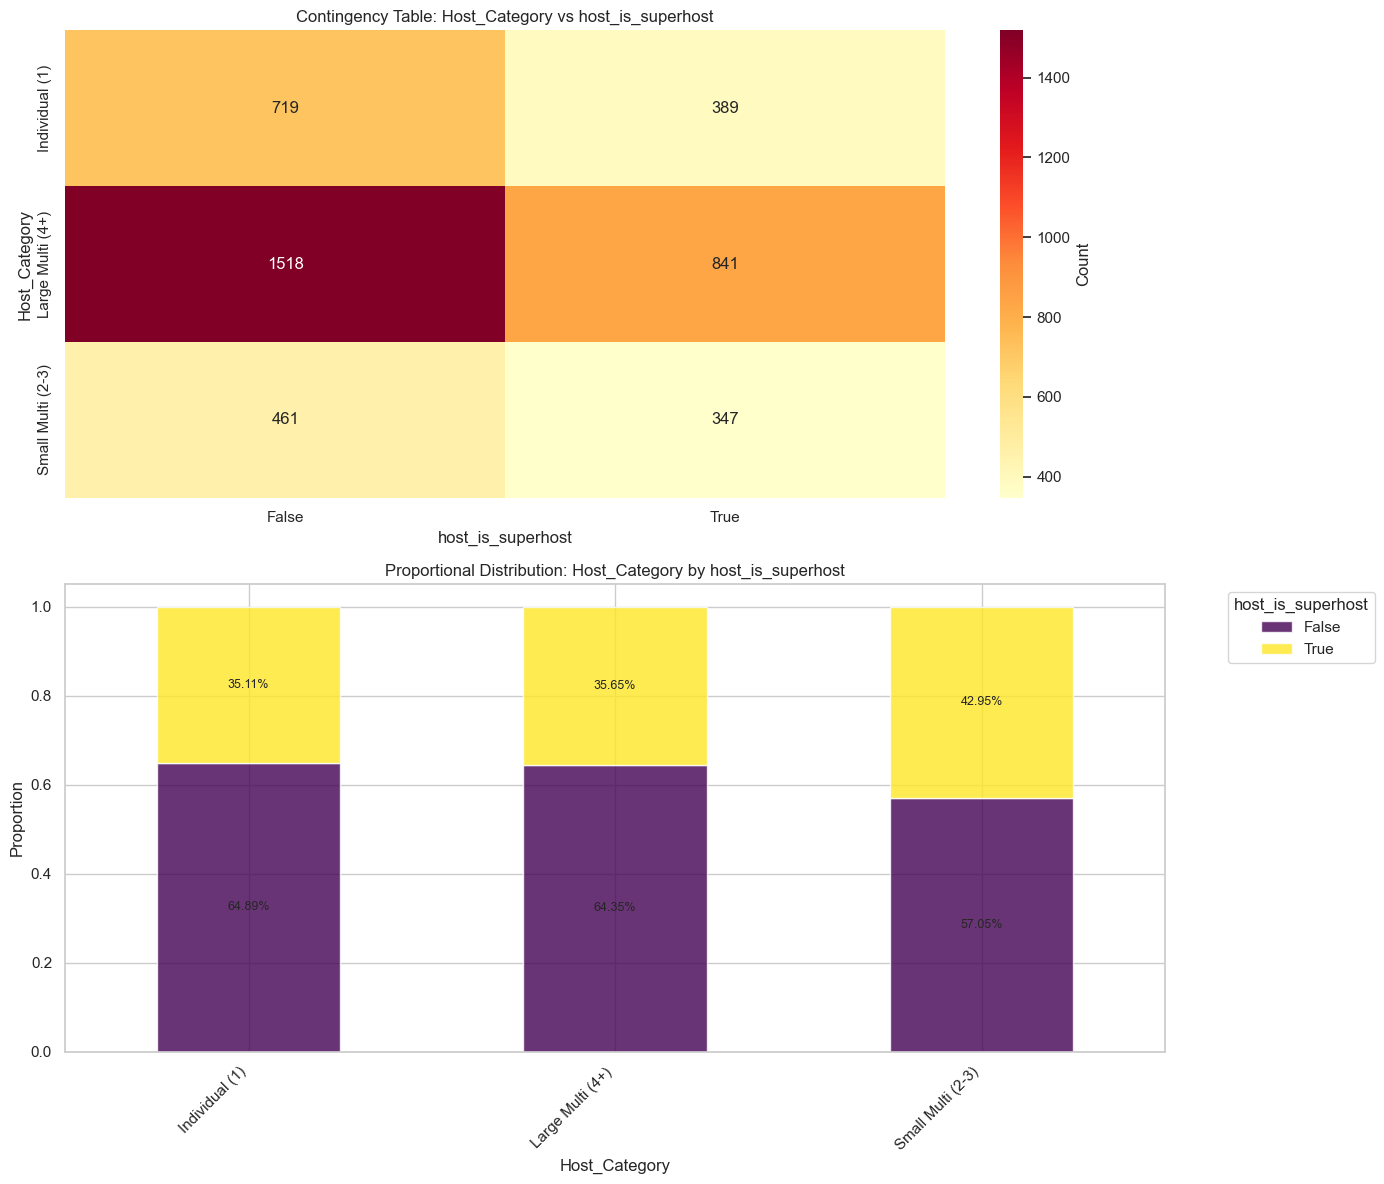

CHI-SQUARE TEST OF INDEPENDENCE: Host_Category vs host_is_superhost

Contingency Table:
host_is_superhost  False  True 
Host_Category                  
Individual (1)       719    389
Large Multi (4+)    1518    841
Small Multi (2-3)    461    347

Test Statistics:
  Chi-square statistic: 15.7938
  Degrees of freedom:   2
  P-value:              0.000372
  Cramér's V:           0.061
  Effect size:          Negligible association
  Significant at α=0.05: YES

Interpretation:
  SIGNIFICANT association detected (p=0.000372). Host_Category and host_is_superhost are related. Negligible association (Cramér's V = 0.061).


In [45]:
i = 1
for var in variables:
    print(str(i) + ' -'  + var.upper())
    print("=" * 50)
    if pd.api.types.is_numeric_dtype(df[var]):
        
        analyze_numeric_variable(df[var])
        analyze_categorical_numerical(df["Host_Category"], df[var])

    else:
        
        analyze_categorical_variable(df[var])
        analyze_categorical_categorical(df["Host_Category"], df[var])
    i += 1

#### Main Findings

### 1 - Estimated revenue

In [7]:
df.sort_values(by="price", ascending=False).head(10)

,id,name,host_id,host_since,host_location,host_acceptance_rate,host_is_superhost,host_total_listings_count,host_identity_verified,neighbourhood,...,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,reviews_per_month,host_category
3396,1247759047568724490,Miltos's House Thessaloniki,568348492,2024-03-22,"Athens, Greece",0.99,False,1442,True,NaN,...,4.40,4.60,4.60,5.00,4.20,4.40,00002876636,True,0.87,Large Multi (4+)
596,32565194,citizen9 urban rooms / live like a citizen,101193924,2016-10-25,None,0.75,False,5,True,"Thessaloniki, Greece",...,4.67,5.00,5.00,4.78,4.56,4.67,00000538922,False,0.17,Large Multi (4+)
3380,1242610104702164856,Μονοκατοικία με Θέα,63261419,2016-03-16,"Panorama, Greece",NaN,False,1,True,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,00002908184,False,NaN,Individual (1)
3661,1299302723989370186,palama Urban Vibes Premium 1-Bedroom apartment,103307879,2016-11-11,"Thessaloniki, Greece",1.00,True,67,True,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,00003175340,True,NaN,Large Multi (4+)
3659,1299298635012554304,palama Urban Vibes Deluxe 1bedroom +Balcony,103307879,2016-11-11,"Thessaloniki, Greece",1.00,True,67,True,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,00003171444,True,NaN,Large Multi (4+)
597,32569288,The City Block 4,241226463,2019-02-05,"Thessaloniki, Greece",1.00,False,7,True,"Thessaloniki, Greece",...,4.79,4.79,5.00,5.00,4.84,4.53,00000598370,False,0.25,Large Multi (4+)
2554,1056625308216830035,"Mavili #2, The Luxury Suites",280458084,2019-07-29,"Thessaloniki, Greece",1.00,False,182,True,NaN,...,4.42,4.36,4.55,4.61,4.12,4.27,00002334179,True,1.86,Large Multi (4+)
1855,834659957824606179,"Horizon #5, The Luxury Suites",280458084,2019-07-29,"Thessaloniki, Greece",1.00,False,182,True,NaN,...,4.75,4.50,4.83,4.83,4.17,4.42,00002393158,True,0.46,Large Multi (4+)
2553,1056616089057596665,"Mavili #1, The Luxury Suites",280458084,2019-07-29,"Thessaloniki, Greece",1.00,False,182,True,NaN,...,4.66,4.52,4.86,4.97,4.59,4.41,00002247165,True,1.63,Large Multi (4+)
759,37339723,The City Block 6,241226463,2019-02-05,"Thessaloniki, Greece",1.00,False,7,True,"Thessaloniki, Greece",...,5.00,5.00,5.00,5.00,5.00,4.67,00000834466,True,0.04,Large Multi (4+)


top 2 listings by price seem a lot like systematic arrors so they will be removed as they seems to affect the estimated revenue

In [18]:
df["price"].describe().round(2)

count    4406.00
mean       67.13
std        55.41
min        10.00
25%        44.00
50%        55.00
75%        75.00
max      1000.00
Name: price, dtype: float64

In [10]:
df["price"].isnull().sum()

np.int64(276)

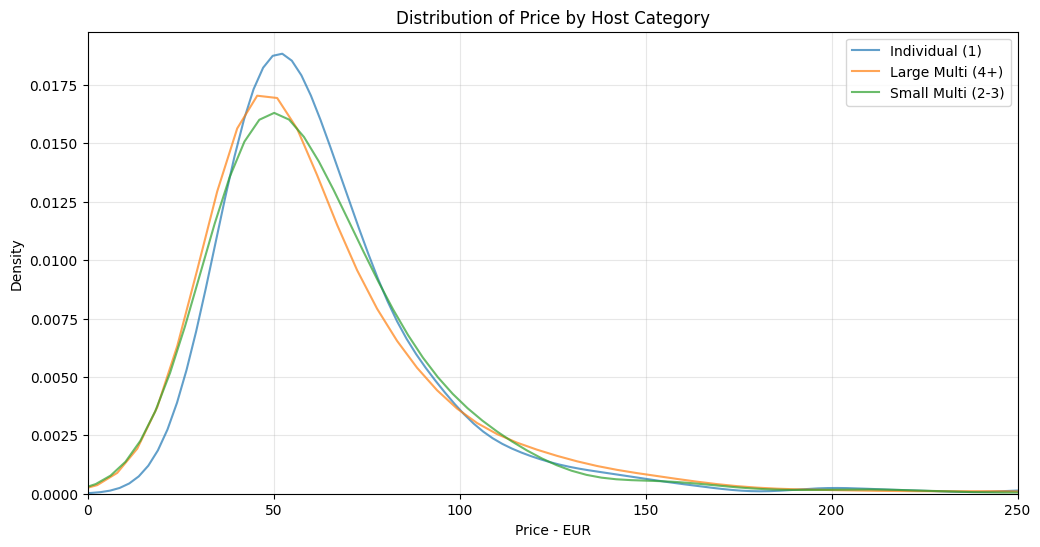

In [20]:
plt.figure(figsize=(12, 6))
for category in df["Host_Category"].unique():
    data = df[df['Host_Category'] == category]['price'].dropna()
    sns.kdeplot(data=data, label=category, alpha=0.7)

plt.xlabel('Price - EUR')
plt.ylabel('Density')
plt.title('Distribution of Price by Host Category')
plt.xlim(0, 250)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


Document the price distribution in your technical notebook with a note that "pricing strategies are consistent across host types, confirming revenue differences reflect operational performance rather than pricing positioning.

In [12]:
df["estimated_revenue_l365d"].describe()

count      4173.000000
mean       3998.912054
std        5747.099720
min           0.000000
25%         468.000000
50%        1980.000000
75%        5712.000000
max      109896.000000
Name: estimated_revenue_l365d, dtype: float64

In [13]:
df["estimated_revenue_l365d"].isnull().sum()    

np.int64(276)

In [14]:
for category in df["host_category"].unique():
    print(f"Host Category: {category}")
    mean = df.loc[df['host_category'] == category]["estimated_revenue_l365d"].mean()
    print(f"  Average Estimated Revenue (last 365 days): {mean:.2f} EUR")


Host Category: Small Multi (2-3)
  Average Estimated Revenue (last 365 days): 3971.27 EUR
Host Category: Individual (1)
  Average Estimated Revenue (last 365 days): 4010.12 EUR
Host Category: Large Multi (4+)
  Average Estimated Revenue (last 365 days): 4002.81 EUR


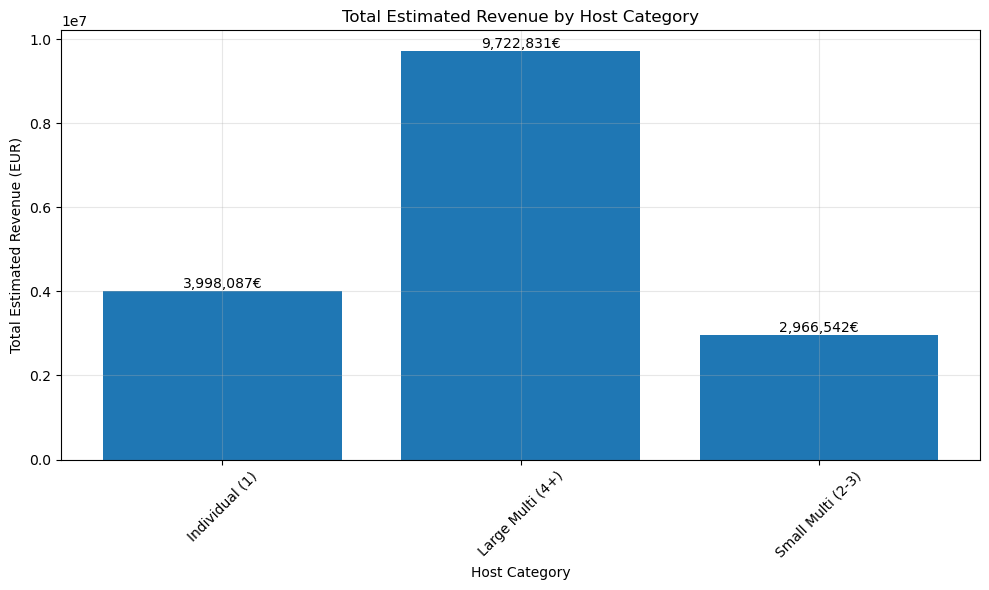

In [15]:
# Create barplot for total estimated revenue by host category
revenue_by_category = df.groupby('host_category')['estimated_revenue_l365d'].sum()

plt.figure(figsize=(10, 6))
bars = plt.bar(revenue_by_category.index, revenue_by_category.values)
plt.xlabel('Host Category')
plt.ylabel('Total Estimated Revenue (EUR)')
plt.title('Total Estimated Revenue by Host Category')
plt.xticks(rotation=45)

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:,.0f}€',
             ha='center', va='bottom')

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

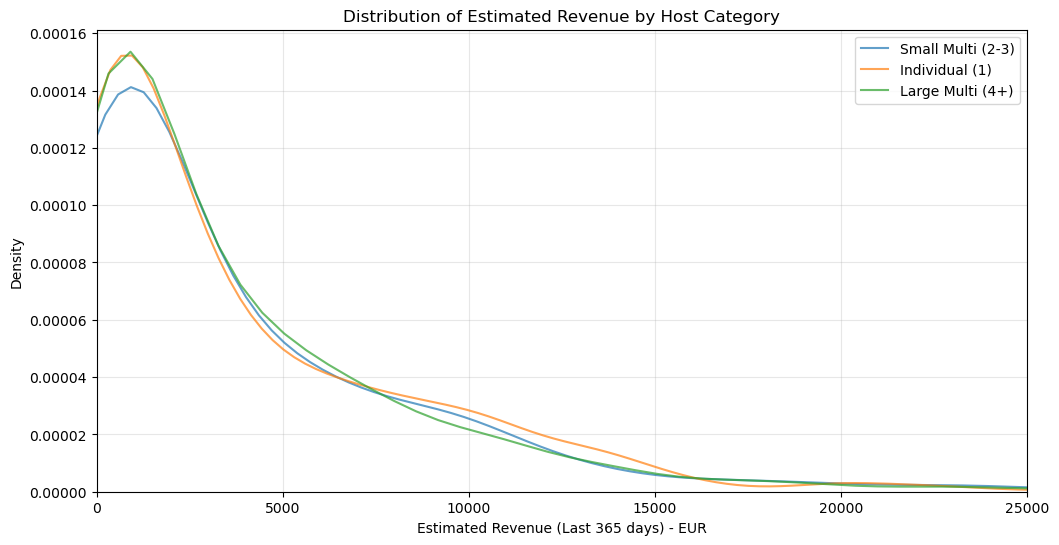

In [16]:


# Create density plot for estimated_revenue_l365d by host_category
plt.figure(figsize=(12, 6))
for category in df["host_category"].unique():
    data = df[df['host_category'] == category]['estimated_revenue_l365d'].dropna()
    sns.kdeplot(data=data, label=category, alpha=0.7)

plt.xlabel('Estimated Revenue (Last 365 days) - EUR')
plt.ylabel('Density')
plt.title('Distribution of Estimated Revenue by Host Category')
plt.xlim(0, 25000)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


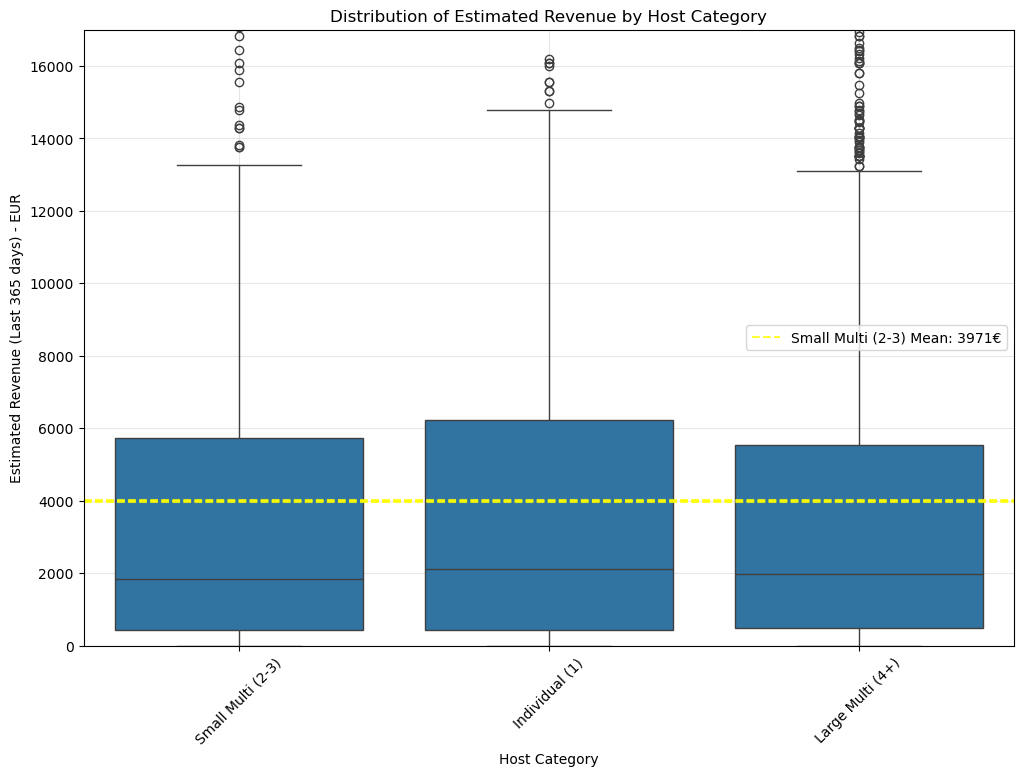

In [17]:

# Create boxplots for estimated_revenue_l365d by host_category
plt.figure(figsize=(12, 8))
sns.boxplot(data=df, x='host_category', y='estimated_revenue_l365d')
plt.xlabel('Host Category')
plt.ylabel('Estimated Revenue (Last 365 days) - EUR')
plt.title('Distribution of Estimated Revenue by Host Category')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
# Add mean lines for each category
for i, category in enumerate(df["host_category"].unique()):
    mean_val = df[df['host_category'] == category]['estimated_revenue_l365d'].mean()
    plt.axhline(y=mean_val, color='yellow', linestyle='--', alpha=0.8, 
                label=f'{category} Mean: {mean_val:.0f}€' if i == 0 else "")
plt.ylim(0, 17000)
plt.legend()
plt.show()

**comments:**
* Average estimated revenue seems to be a little larger for individual hosts followed closely by multi hosts.
* Individuals and multi hosts show similar distribution until 3000 euros, then 4+ shows bigger density in the 3000 to 7000 range and lastly the indiual listing hosts show bigger density in the 7000 to 15000 range
* 2-3 category isalways below each of those two although close 

In [18]:
df.iloc[df["estimated_revenue_l365d"].sort_values(ascending=False)[:10].index]

,id,name,host_id,host_since,host_location,host_acceptance_rate,host_is_superhost,host_total_listings_count,host_identity_verified,neighbourhood,...,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,reviews_per_month,host_category
2554,1056625308216830035,"Mavili #2, The Luxury Suites",280458084,2019-07-29,"Thessaloniki, Greece",1.00,False,182,True,NaN,...,4.42,4.36,4.55,4.61,4.12,4.27,00002334179,True,1.86,Large Multi (4+)
2555,1057031591588397411,Tinker Bell by halu! : Colorful family apt,251290631,2019-03-26,"Thessaloniki, Greece",1.00,None,267,True,"Thessaloniki, Greece",...,4.50,4.42,4.50,4.42,4.25,4.33,00002423150,True,0.70,Large Multi (4+)
2278,973767464301762289,Charming Urban Retreat,128221426,2017-04-30,"Brussels, Belgium",NaN,False,1,True,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,00002303416,False,NaN,Individual (1)
24,5170079,"""The House of Art"" - 2' from Metro Station",26719518,2015-01-26,"Thessaloniki, Greece",1.00,False,2,True,"Thessaloniki, Greece",...,4.85,4.91,4.92,4.92,4.60,4.80,00000034826,False,3.67,Small Multi (2-3)
3142,1190221462441562542,Orchidea Bianca Apt,32216964,2015-04-29,"Thessaloniki, Greece",NaN,False,30,True,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,00000459846,True,NaN,Large Multi (4+)
2887,1136105834697145322,white & grey Diamond,293672648,2019-09-10,"Thessaloniki, Greece",1.00,False,6,True,NaN,...,4.44,4.29,4.58,4.29,4.29,4.29,00002358779,True,3.15,Large Multi (4+)
3929,1339580067822800773,JORDAN's ROOM 21,156282533,2017-10-26,"Thessaloniki, Greece",1.00,False,12,True,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,00003087095,True,NaN,Large Multi (4+)
3435,1260140299473114921,Glow Haven suites,561746986,2024-02-12,"Sofia, Bulgaria",0.98,True,2,True,"Thessaloniki, Greece",...,4.85,5.00,5.00,5.00,4.54,4.92,01254038396,True,1.49,Small Multi (2-3)
2097,910576600016343828,#7Ioanna Apartments,434347481,2021-12-02,"Thessaloniki, Greece",1.00,None,36,True,NaN,...,4.87,4.94,4.84,4.90,4.49,4.68,00002112721,True,2.63,Large Multi (4+)
2340,990331926139143227,"Avenue Superior Apartment, Nilie Hospitality MGMT",239769711,2019-01-29,"Thessaloniki, Greece",1.00,False,390,True,NaN,...,4.67,4.27,4.85,4.68,4.89,4.56,00001357974,True,3.18,Large Multi (4+)


### 2 - Occupancy rate

In [19]:
df["estimated_occupancy_l365d"].describe()

count    4449.000000
mean       65.798157
std        75.536473
min         0.000000
25%         6.000000
50%        36.000000
75%       102.000000
max       255.000000
Name: estimated_occupancy_l365d, dtype: float64

In [20]:
df["estimated_occupancy_l365d"].isnull().sum()

np.int64(0)

In [21]:
for category in df["host_category"].unique():
    print(f"Host Category: {category}")
    mean = df.loc[df['host_category'] == category]["estimated_occupancy_l365d"].mean()
    print(f"  Average Estimated Occupancy (last 365 days): {mean:.2f} days")


Host Category: Small Multi (2-3)
  Average Estimated Occupancy (last 365 days): 64.87 days
Host Category: Individual (1)
  Average Estimated Occupancy (last 365 days): 66.53 days
Host Category: Large Multi (4+)
  Average Estimated Occupancy (last 365 days): 65.78 days


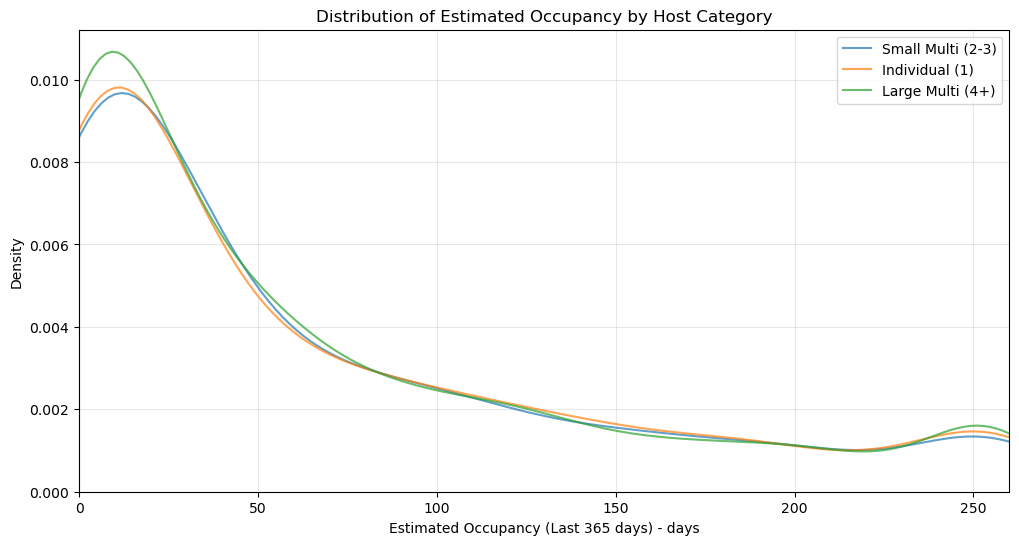

In [22]:
# Create density plot for estimated_revenue_l365d by host_category
plt.figure(figsize=(12, 6))
for category in df["host_category"].unique():
    data = df[df['host_category'] == category]['estimated_occupancy_l365d'].dropna()
    sns.kdeplot(data=data, label=category, alpha=0.7)

plt.xlabel('Estimated Occupancy (Last 365 days) - days')
plt.ylabel('Density')
plt.title('Distribution of Estimated Occupancy by Host Category')
plt.xlim(0, 260)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


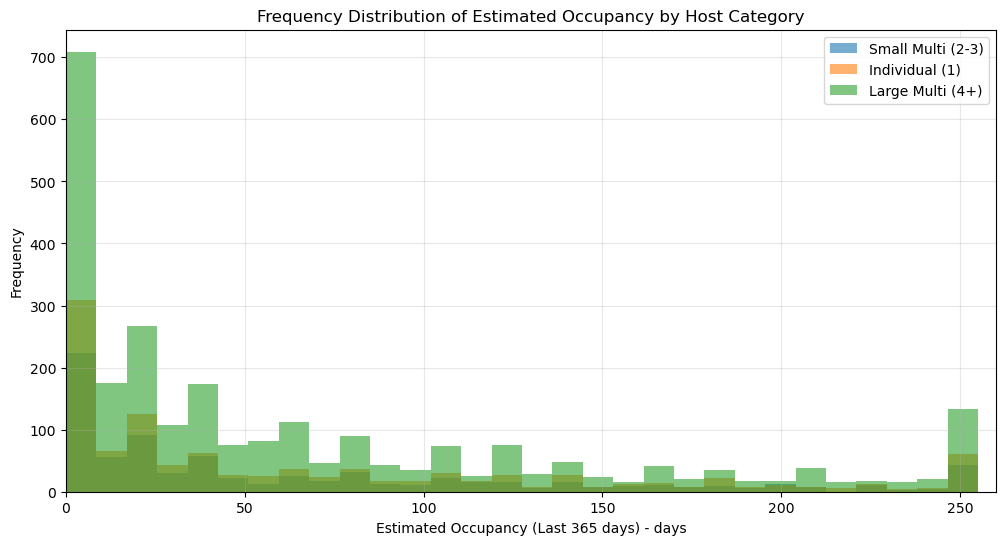

In [23]:
# Create frequency histograms for estimated_occupancy_l365d by host_category
plt.figure(figsize=(12, 6))
for category in df["host_category"].unique():
    data = df[df['host_category'] == category]['estimated_occupancy_l365d'].dropna()
    plt.hist(data, bins=30, alpha=0.6, label=category, density=False)

plt.xlabel('Estimated Occupancy (Last 365 days) - days')
plt.ylabel('Frequency')
plt.title('Frequency Distribution of Estimated Occupancy by Host Category')
plt.xlim(0, 260)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [24]:
df[["estimated_occupancy_l365d", "estimated_revenue_l365d", "price"]].corr()

,estimated_occupancy_l365d,estimated_revenue_l365d,price
estimated_occupancy_l365d,1.000000,0.740199,-0.110070
estimated_revenue_l365d,0.740199,1.000000,0.241321
price,-0.110070,0.241321,1.000000


* nothing importand to note here, all categories show the same characteristics

### 3 - Reviews per month

In [25]:
df["reviews_per_month"].describe()

count    3950.000000
mean        1.461003
std         1.357813
min         0.010000
25%         0.460000
50%         1.050000
75%         2.040000
max        15.000000
Name: reviews_per_month, dtype: float64

In [26]:
df["reviews_per_month"].isnull().sum()

np.int64(499)

In [27]:
for category in df["host_category"].unique():
    print(f"Host Category: {category}")
    mean = df.loc[df['host_category'] == category]["reviews_per_month"].mean()
    print(f"  Average Reviews per Month: {mean:.2f} reviews")

Host Category: Small Multi (2-3)
  Average Reviews per Month: 1.39 reviews
Host Category: Individual (1)
  Average Reviews per Month: 1.48 reviews
Host Category: Large Multi (4+)
  Average Reviews per Month: 1.48 reviews


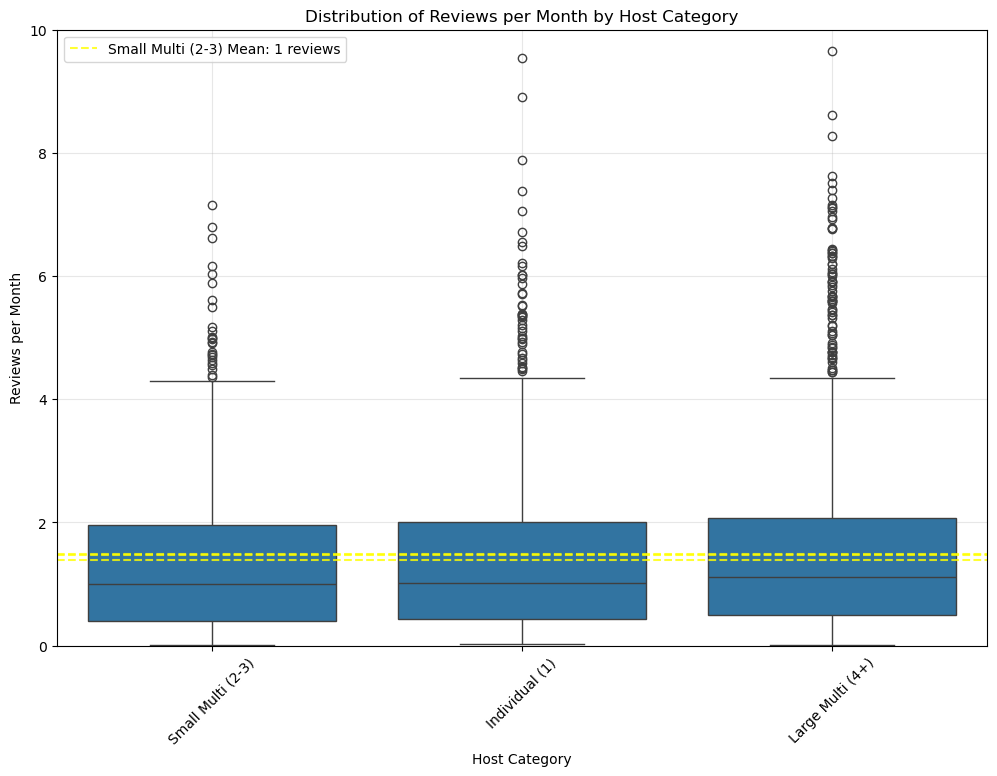

In [28]:

# Create boxplots for reviews_per_month by host_category
plt.figure(figsize=(12, 8))
sns.boxplot(data=df, x='host_category', y='reviews_per_month')
plt.xlabel('Host Category')
plt.ylabel('Reviews per Month')
plt.title('Distribution of Reviews per Month by Host Category')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
# Add mean lines for each category
for i, category in enumerate(df["host_category"].unique()):
    mean_val = df[df['host_category'] == category]['reviews_per_month'].mean()
    plt.axhline(y=mean_val, color='yellow', linestyle='--', alpha=0.8, 
                label=f'{category} Mean: {mean_val:.0f} reviews' if i == 0 else "")
plt.ylim(0, 10)
plt.legend()
plt.show()

### 4 - Reviews ratings

In [29]:
df["review_scores_rating"].isnull().sum()

np.int64(499)

In [30]:
df["review_scores_rating"].dropna().describe()

count    3950.000000
mean        4.730008
std         0.395369
min         1.000000
25%         4.670000
50%         4.850000
75%         4.970000
max         5.000000
Name: review_scores_rating, dtype: float64

In [31]:
df.loc[df["review_scores_rating"].isnull()]

,id,name,host_id,host_since,host_location,host_acceptance_rate,host_is_superhost,host_total_listings_count,host_identity_verified,neighbourhood,...,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,reviews_per_month,host_category
178,17755730,Business Flat Stavroupoli,117477639,2017-02-21,None,1.00,False,3,True,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,00002499140,False,NaN,Small Multi (2-3)
198,18959007,Fabulous house in Panorama Thessaloniki,12928977,2014-03-08,"Thessaloniki, Greece",NaN,False,3,True,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,00000040661,True,NaN,Small Multi (2-3)
466,28510642,Σοφίτα Σε Thessaloniki,215190004,2018-09-13,"Thessaloniki, Greece",NaN,False,3,True,"Thessaloniki, Greece",...,NaN,NaN,NaN,NaN,NaN,NaN,00000508636,True,NaN,Small Multi (2-3)
933,42482026,halu! Upscale Contemporary City Centre Penthouse,251290631,2019-03-26,"Thessaloniki, Greece",1.00,None,267,True,"Thessaloniki, Greece",...,NaN,NaN,NaN,NaN,NaN,NaN,00001124618,False,NaN,Large Multi (4+)
985,44175363,Thessaloniki - Quiet Loft Apartment in the City,154443586,2017-10-13,"Thessaloniki, Greece",1.00,False,2,True,"Thessaloniki, Greece",...,NaN,NaN,NaN,NaN,NaN,NaN,00001030930,False,NaN,Small Multi (2-3)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4446,1446980591343247146,White Lotus #Skgbnb,1977386,2012-03-20,"Thessaloniki, Greece",1.00,True,104,True,"Thessaloniki, Greece",...,NaN,NaN,NaN,NaN,NaN,NaN,00003412164,True,NaN,Large Multi (4+)
4447,1447017899210584543,F & B Collection - Flat for 3,31131449,2015-04-13,"Thessaloniki, Greece",NaN,False,93,True,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,00003258473,True,NaN,Large Multi (4+)
4448,1447723147900850232,villa 8 studio delux,103307879,2016-11-11,"Thessaloniki, Greece",1.00,True,67,True,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,00003392735,True,NaN,Large Multi (4+)
4449,1447752389031362434,Ανακαινισμένο με δροσερή αυλή!,702402710,2025-06-20,None,1.00,False,1,True,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,00003305500,False,NaN,Individual (1)


In [32]:
for category in df["host_category"].unique():
    print(f"Host Category: {category}")
    mean = df.loc[df['host_category'] == category]["review_scores_rating"].dropna().mean()
    print(f"  Average Review Scores Rating: {mean:.2f} stars")

Host Category: Small Multi (2-3)
  Average Review Scores Rating: 4.81 stars
Host Category: Individual (1)
  Average Review Scores Rating: 4.84 stars
Host Category: Large Multi (4+)
  Average Review Scores Rating: 4.66 stars


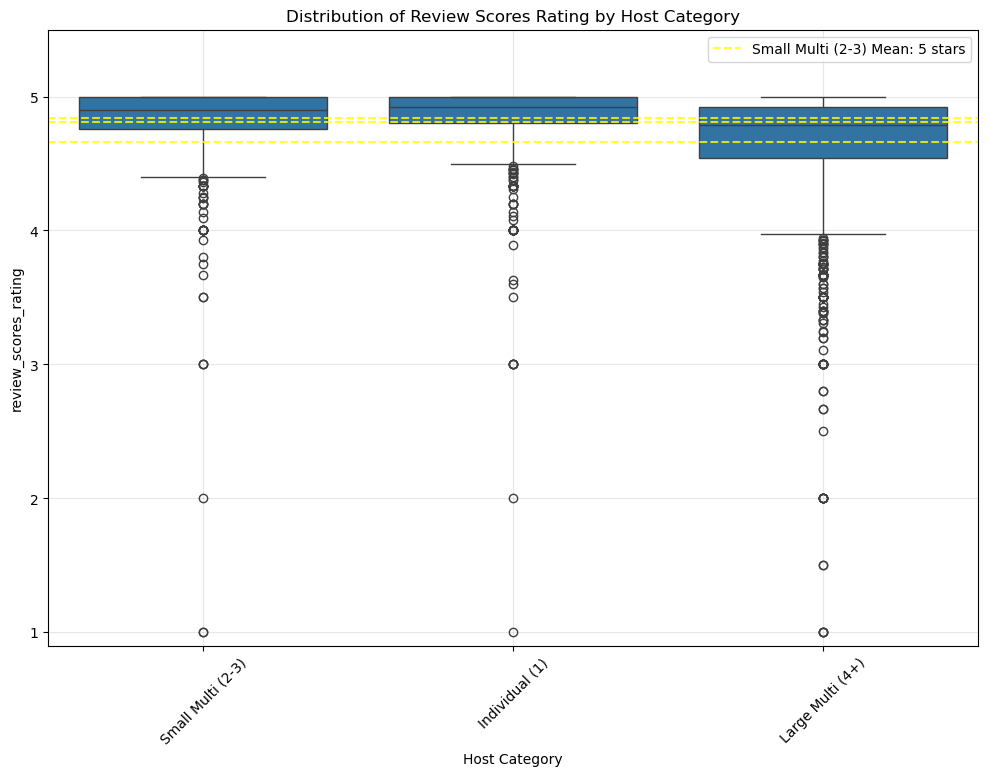

In [33]:
# Create boxplots for review_scores_rating by host_category
plt.figure(figsize=(12, 8))
sns.boxplot(data=df, x='host_category', y='review_scores_rating')
plt.xlabel('Host Category')
plt.ylabel('review_scores_rating')
plt.title('Distribution of Review Scores Rating by Host Category')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
# Add mean lines for each category
for i, category in enumerate(df["host_category"].unique()):
    mean_val = df[df['host_category'] == category]['review_scores_rating'].dropna().mean()
    plt.axhline(y=mean_val, color='yellow', linestyle='--', alpha=0.8, 
                label=f'{category} Mean: {mean_val:.0f} stars' if i == 0 else "")
plt.ylim(0.9, 5.5)
plt.legend()
plt.show()

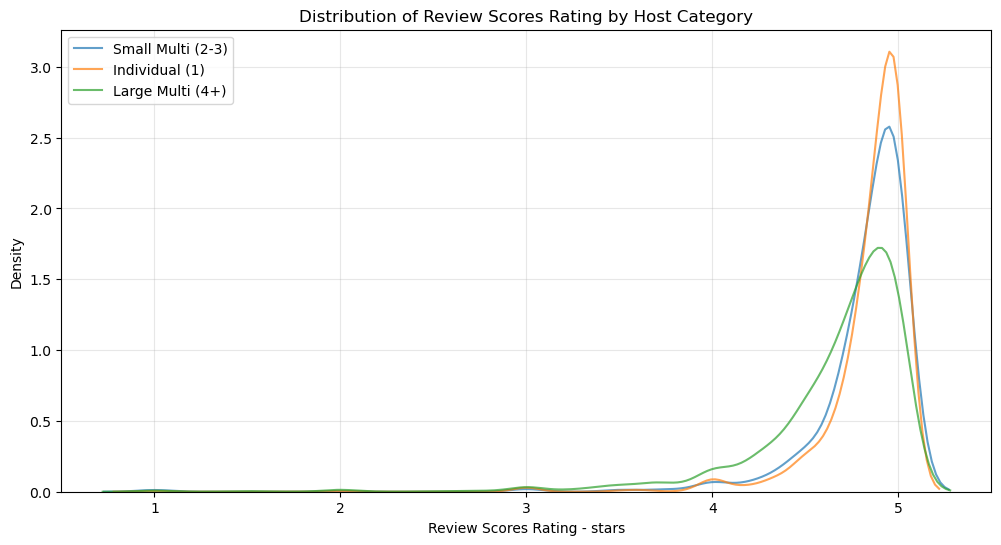

In [34]:
# Create density plot for review_scores_rating by host_category
plt.figure(figsize=(12, 6))
for category in df["host_category"].unique():
    data = df[df['host_category'] == category]['review_scores_rating'].dropna()
    sns.kdeplot(data=data, label=category, alpha=0.7)

plt.xlabel('Review Scores Rating - stars')
plt.ylabel('Density')
plt.title('Distribution of Review Scores Rating by Host Category')
plt.xlim(0.5, 5.5)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


**comments:**
* individual scores seem more confident and concentrated on higher vales, whereas 4+ category seems to exhibit a mean value lower than the overall average 

### 5 - Acceptance rate

In [35]:
df["host_acceptance_rate"].isnull().sum()

np.int64(486)

In [36]:
df["host_acceptance_rate"].describe()

count    3963.000000
mean        0.941148
std         0.178714
min         0.000000
25%         0.990000
50%         1.000000
75%         1.000000
max         1.000000
Name: host_acceptance_rate, dtype: float64

In [37]:
df.loc[df["host_acceptance_rate"]==0]

,id,name,host_id,host_since,host_location,host_acceptance_rate,host_is_superhost,host_total_listings_count,host_identity_verified,neighbourhood,...,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,reviews_per_month,host_category
0,218831,Sea-life apartment,137588,2010-06-03,"Thessalonika, Greece",0.0,False,2,False,"Kalamaria Municipality, Greece",...,5.00,4.00,5.00,5.0,5.00,5.00,00000049330,False,0.02,Small Multi (2-3)
13,2639807,Apollon - Central apartment,13516901,2014-03-25,"Thessaloniki, Greece",0.0,False,1,True,NaN,...,4.92,4.88,4.90,4.9,4.65,4.72,00000161920,False,0.79,Individual (1)
32,6408408,EVANGELIA: Only Good News Here...,33423743,2015-05-15,"Thessaloniki, Greece",0.0,False,3,True,"Thessaloníki, Greece",...,4.85,4.74,4.89,5.0,4.88,4.80,00000378638,False,0.54,Small Multi (2-3)
77,11651643,City center elegant loft,36326447,2015-06-21,"Thessaloniki, Greece",0.0,False,2,True,"Thessaloniki, Greece",...,5.00,4.97,5.00,5.0,5.00,4.95,00000209181,False,0.62,Small Multi (2-3)
100,12839242,Million dollars view,70104544,2016-05-03,"Thessaloniki, Greece",0.0,False,1,True,"Thessaloniki, Makedonia Thraki, Greece",...,4.88,4.71,4.96,4.9,4.77,4.93,00000144789,False,1.20,Individual (1)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4127,1378064487237445599,Άνετο διαμέρισμα με ένα δωμάτιο.,318973561,2019-12-19,"Thessaloniki, Greece",0.0,False,1,True,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,00003251136,False,NaN,Individual (1)
4134,1379728058017266732,Δωμάτιο Θεσσαλονίκη,682925599,2025-03-07,None,0.0,False,1,True,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,14919365701,False,NaN,Individual (1)
4319,1420470401996555460,Four Suns Loft,14852638,2014-04-28,"Skopje, North Macedonia",0.0,False,1,True,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,00003312231,False,NaN,Individual (1)
4346,1425082103671191566,il Panorama,563383717,2024-02-22,None,0.0,False,1,True,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,00003207999,False,NaN,Individual (1)


In [38]:
zero_acceptance = df[df['host_acceptance_rate'] == 0]

print("Average availability:", 
      zero_acceptance['availability_365'].mean())
print("Average revenue estimates:", 
      zero_acceptance['estimated_revenue_l365d'].mean())

Average availability: 219.28125
Average revenue estimates: 10.714285714285714


In [39]:
inactive_listings = df.loc[(df["host_acceptance_rate"]==0) & 
                           (df["estimated_occupancy_l365d"]==0) & 
                           (df["number_of_reviews_ly"]==0)]
inactive_listings

,id,name,host_id,host_since,host_location,host_acceptance_rate,host_is_superhost,host_total_listings_count,host_identity_verified,neighbourhood,...,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,reviews_per_month,host_category
0,218831,Sea-life apartment,137588,2010-06-03,"Thessalonika, Greece",0.0,False,2,False,"Kalamaria Municipality, Greece",...,5.00,4.00,5.00,5.00,5.00,5.00,00000049330,False,0.02,Small Multi (2-3)
13,2639807,Apollon - Central apartment,13516901,2014-03-25,"Thessaloniki, Greece",0.0,False,1,True,NaN,...,4.92,4.88,4.90,4.90,4.65,4.72,00000161920,False,0.79,Individual (1)
32,6408408,EVANGELIA: Only Good News Here...,33423743,2015-05-15,"Thessaloniki, Greece",0.0,False,3,True,"Thessaloníki, Greece",...,4.85,4.74,4.89,5.00,4.88,4.80,00000378638,False,0.54,Small Multi (2-3)
77,11651643,City center elegant loft,36326447,2015-06-21,"Thessaloniki, Greece",0.0,False,2,True,"Thessaloniki, Greece",...,5.00,4.97,5.00,5.00,5.00,4.95,00000209181,False,0.62,Small Multi (2-3)
100,12839242,Million dollars view,70104544,2016-05-03,"Thessaloniki, Greece",0.0,False,1,True,"Thessaloniki, Makedonia Thraki, Greece",...,4.88,4.71,4.96,4.90,4.77,4.93,00000144789,False,1.20,Individual (1)
105,13311881,"Penthouse apartment with view, close to the ce...",75230884,2016-06-01,"Thessaloniki, Greece",0.0,False,2,True,"Thessaloniki, Greece",...,4.88,4.87,4.96,4.98,4.66,4.83,00000337588,False,2.80,Small Multi (2-3)
240,20768326,Pretty flat at the city of Thessaloniki,148785081,2017-09-02,"Thessaloniki, Greece",0.0,False,1,True,NaN,...,4.63,4.44,4.75,4.63,4.25,4.31,00001646333,False,0.44,Individual (1)
356,24283295,Λειτουργικό διαμερισμα,183161769,2018-04-08,Greece,0.0,False,1,True,"Eleftherio Kordelio, Greece",...,5.00,5.00,5.00,5.00,5.00,5.00,00000839067,False,0.02,Individual (1)
369,24612348,Aristoteles Square Apartment,114781155,2017-02-04,"Thessaloniki, Greece",0.0,False,2,True,"Thessaloniki, Greece",...,5.00,5.00,5.00,5.00,5.00,5.00,00002257456,False,0.01,Small Multi (2-3)
440,27887898,Elena's hope - home,210672602,2018-08-20,"Thessaloniki, Greece",0.0,False,1,True,"Thessaloniki, Greece",...,5.00,4.80,5.00,5.00,5.00,5.00,00000378751,False,0.06,Individual (1)


the above listings seem to be somehow inactive and will be removed for the analysis of the current variable

In [40]:
df_active = df.drop(index=inactive_listings.index)
for category in df_active["host_category"].unique():
    print(f"Host Category: {category}")
    mean = df_active.loc[df_active['host_category'] == category]["host_acceptance_rate"].mean()
    print(f"  Average Host Acceptance Rate: {mean:.2f}")

Host Category: Individual (1)
  Average Host Acceptance Rate: 0.94
Host Category: Large Multi (4+)
  Average Host Acceptance Rate: 0.97
Host Category: Small Multi (2-3)
  Average Host Acceptance Rate: 0.93


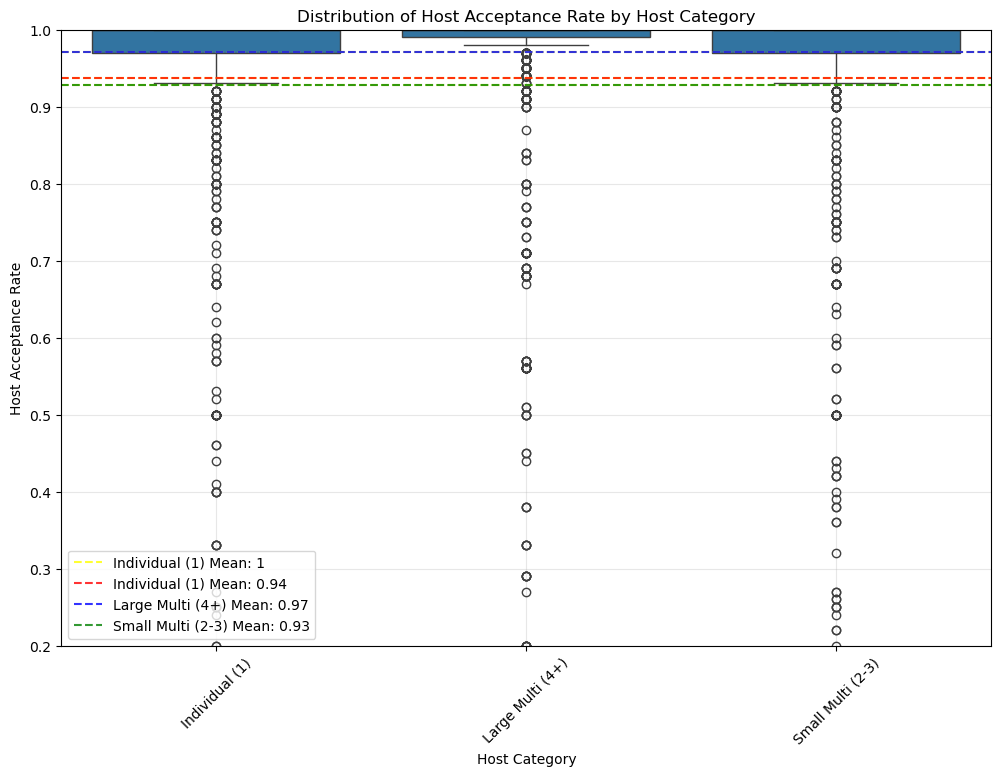

In [41]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=df_active, x='host_category', y='host_acceptance_rate')
plt.xlabel('Host Category')
plt.ylabel('Host Acceptance Rate')
plt.title('Distribution of Host Acceptance Rate by Host Category')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
# Add mean lines for each category
for i, category in enumerate(df_active["host_category"].unique()):
    mean_val = df_active[df_active['host_category'] == category]['host_acceptance_rate'].dropna().mean()
    plt.axhline(y=mean_val, color='yellow', linestyle='--', alpha=0.8, 
                label=f'{category} Mean: {mean_val:.0f} ' if i == 0 else "")
colors = ['red', 'blue', 'green']
for i, category in enumerate(df_active["host_category"].unique()):
    mean_val = df_active[df_active['host_category'] == category]['host_acceptance_rate'].dropna().mean()
    plt.axhline(y=mean_val, color=colors[i], linestyle='--', alpha=0.8, 
                label=f'{category} Mean: {mean_val:.2f}')
plt.ylim(0.2, 1)
plt.legend()
plt.show()

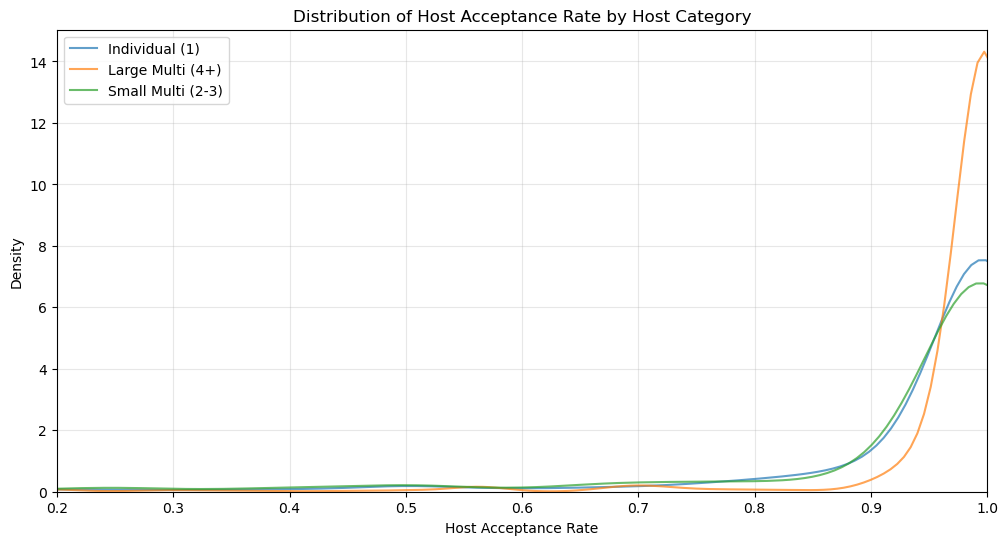

In [42]:
# Create density plot for review_scores_rating by host_category
plt.figure(figsize=(12, 6))
for category in df_active["host_category"].unique():
    data = df_active[df_active['host_category'] == category]['host_acceptance_rate'].dropna()
    sns.kdeplot(data=data, label=category, alpha=0.7)

plt.xlabel('Host Acceptance Rate')
plt.ylabel('Density')
plt.title('Distribution of Host Acceptance Rate by Host Category')
plt.xlim(0.2, 1)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


**comment**
* multi hosts seem to be more willing to accept customers showing a more professional approach

### 7 - Superhost percentage

In [43]:
df["host_is_superhost"].isnull().sum()

np.int64(340)

In [44]:
for category in df["host_category"].unique():
    print(f"Host Category: {category}")
    print(df.loc[df['host_category'] == category]["host_is_superhost"].dropna().value_counts(normalize=True))
    print(df.loc[df['host_category'] == category]["host_is_superhost"].isnull().sum())


Host Category: Small Multi (2-3)
host_is_superhost
False    0.570681
True     0.429319
Name: proportion, dtype: float64
29
Host Category: Individual (1)
host_is_superhost
False    0.658627
True     0.341373
Name: proportion, dtype: float64
0
Host Category: Large Multi (4+)
host_is_superhost
False    0.633877
True     0.366123
Name: proportion, dtype: float64
311


**comment:**
* surprisingly the 2-3 category has the most superhosts (maybe a sign of hosts that want to put more effort in growing their rental business?)
* individuals have the lowest rate of superhosts but not far away from multihosts

### 8 - Availability 365

In [45]:
df["availability_365"].isnull().sum()

np.int64(0)

In [46]:
no_availability = df.loc[df["availability_365"]==0]
no_availability

,id,name,host_id,host_since,host_location,host_acceptance_rate,host_is_superhost,host_total_listings_count,host_identity_verified,neighbourhood,...,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,reviews_per_month,host_category
0,218831,Sea-life apartment,137588,2010-06-03,"Thessalonika, Greece",0.00,False,2,False,"Kalamaria Municipality, Greece",...,5.00,4.00,5.00,5.00,5.00,5.00,00000049330,False,0.02,Small Multi (2-3)
12,2525130,Luxurious fabulous modern studio - Panorama ce...,12928977,2014-03-08,"Thessaloniki, Greece",NaN,False,3,True,"Panorama, Makedonia Thraki, Greece",...,4.00,4.00,5.00,5.00,5.00,4.00,00000040650,True,0.05,Small Multi (2-3)
37,6773050,Penthouse in the City Centre !!,25211962,2014-12-26,"Thessaloniki, Greece",1.00,True,2,True,"Thessaloníki, Greece",...,4.78,4.87,4.96,4.96,4.88,4.83,00003249285,True,0.69,Small Multi (2-3)
55,8610663,5* LOFT PILAIA -splendid view 360*,35478692,2015-06-10,"Makedonia Thraki, Greece",1.00,False,1,True,NaN,...,4.71,4.92,4.89,4.87,4.85,4.72,00000162447,True,0.43,Individual (1)
64,10483750,CITY CENTRAL 1 BEDROOM FLAT,54039142,2016-01-10,"Thessaloniki, Greece",NaN,False,1,True,NaN,...,4.75,4.79,4.86,4.82,4.86,4.64,00000157608,False,0.24,Individual (1)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3902,1333135394319175698,Studio Apartment 35,599770135,2024-09-03,None,1.00,False,45,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,00003176645,True,NaN,Large Multi (4+)
3925,1338584833249174711,Cozy apartment centrally located,45358495,2015-09-29,"Athens, Greece",0.00,False,2,True,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,00003042921,False,NaN,Small Multi (2-3)
3958,1344913730539549246,Thessaloniki city center Apartment,110611523,2017-01-09,Greece,0.83,False,11,True,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,00003196616,True,NaN,Large Multi (4+)
4104,1373769925563050106,Amelie by halu! 2-BD modern apt,251290631,2019-03-26,"Thessaloniki, Greece",1.00,None,267,True,"Thessaloniki, Greece",...,NaN,NaN,NaN,NaN,NaN,NaN,00003243519,True,NaN,Large Multi (4+)


159 listings with zero availability data. maybe a systematic error, faulty listings or inactive ones. they will be removed for validation purposes

In [47]:
df_available = df.drop(index=no_availability.index)
df_available.shape

(4290, 43)

In [48]:
df_available[["availability_30", "availability_90", "availability_365"]].describe()

,availability_30,availability_90,availability_365
count,4290.00000,4290.000000,4290.000000
mean,17.20303,61.189744,243.851515
std,9.71926,25.481246,106.372674
min,0.00000,0.000000,1.000000
25%,9.00000,46.000000,162.000000
50%,19.00000,68.000000,266.000000
75%,26.00000,83.000000,343.000000
max,30.00000,90.000000,365.000000


In [49]:
for category in df_available["host_category"].unique():
    print(f"Host Category: {category}")
    mean = df_available.loc[df_available['host_category'] == category][["availability_30", "availability_90", "availability_365"]].dropna().mean()
    print(f"  Average Availability (days)")
    print(mean.round(2), "\n")

Host Category: Individual (1)
  Average Availability (days)
availability_30      15.32
availability_90      55.17
availability_365    226.43
dtype: float64 

Host Category: Large Multi (4+)
  Average Availability (days)
availability_30      18.42
availability_90      65.19
availability_365    256.59
dtype: float64 

Host Category: Small Multi (2-3)
  Average Availability (days)
availability_30      15.73
availability_90      56.20
availability_365    225.55
dtype: float64 



**comment**
* small multi and invidual listing host show similar availability patterns
* large multi seem to have more days of availability on average which indicates larger particiapation in the market

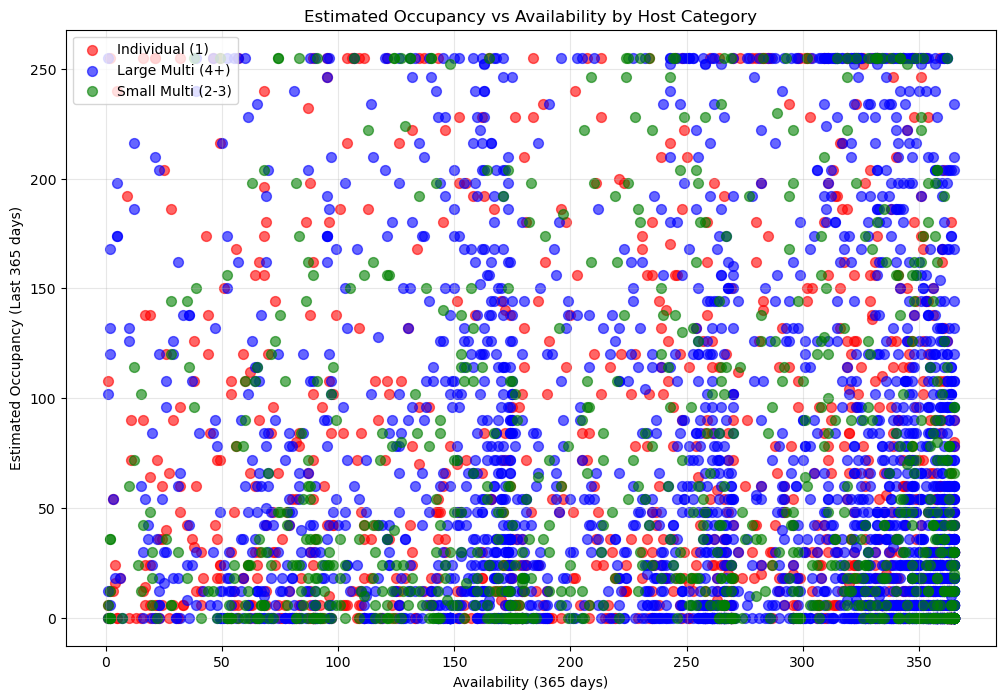

In [50]:
plt.figure(figsize=(12, 8))

# Create scatter plot with different colors for each host category
colors = ['red', 'blue', 'green']
for i, category in enumerate(df_available["host_category"].unique()):
    category_data = df_available[df_available['host_category'] == category]
    plt.scatter(category_data['availability_365'], category_data['estimated_occupancy_l365d'], 
                c=colors[i], alpha=0.6, label=category, s=50)

plt.xlabel('Availability (365 days)')
plt.ylabel('Estimated Occupancy (Last 365 days)')
plt.title('Estimated Occupancy vs Availability by Host Category')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

correlation analysis

In [51]:
# Correlation analysis by host category
for category in ['Individual (1)', 'Small Multi (2-3)', 'Large Multi (4+)']:
    cat_data = df[df['host_category'] == category]
    
    # Key correlations
    corr_matrix = cat_data[['host_acceptance_rate', 'review_scores_rating', 
                             'estimated_revenue_l365d', 'estimated_occupancy_l365d',
                             'availability_365']].corr()
    
    print(f"\n{category} Correlations:")
    print(corr_matrix)


Individual (1) Correlations:
                           host_acceptance_rate  review_scores_rating  \
host_acceptance_rate                   1.000000              0.128554   
review_scores_rating                   0.128554              1.000000   
estimated_revenue_l365d                0.236538              0.142796   
estimated_occupancy_l365d              0.261697              0.126574   
availability_365                      -0.004002             -0.044351   

                           estimated_revenue_l365d  estimated_occupancy_l365d  \
host_acceptance_rate                      0.236538                   0.261697   
review_scores_rating                      0.142796                   0.126574   
estimated_revenue_l365d                   1.000000                   0.862635   
estimated_occupancy_l365d                 0.862635                   1.000000   
availability_365                         -0.002381                   0.042462   

                           availability_365 

In [52]:
# Compare superhosts vs non-superhosts within each category
for category in ['Individual (1)', 'Small Multi (2-3)', 'Large Multi (4+)']:
    cat_data = df[df['host_category'] == category]
    
    superhosts = cat_data[cat_data['host_is_superhost'] == True]
    non_superhosts = cat_data[cat_data['host_is_superhost'] == False]
    
    print(f"\n{category}:")
    print(f"Superhost avg revenue: {superhosts['estimated_revenue_l365d'].mean():.2f}")
    print(f"Non-superhost avg revenue: {non_superhosts['estimated_revenue_l365d'].mean():.2f}")
    print(f"Superhost avg rating: {superhosts['review_scores_rating'].mean():.2f}")
    print(f"Non-superhost avg rating: {non_superhosts['review_scores_rating'].mean():.2f}")


Individual (1):
Superhost avg revenue: 7704.46
Non-superhost avg revenue: 2002.82
Superhost avg rating: 4.91
Non-superhost avg rating: 4.79

Small Multi (2-3):
Superhost avg revenue: 6661.96
Non-superhost avg revenue: 1770.95
Superhost avg rating: 4.90
Non-superhost avg rating: 4.74

Large Multi (4+):
Superhost avg revenue: 5214.93
Non-superhost avg revenue: 2997.85
Superhost avg rating: 4.85
Non-superhost avg rating: 4.52


### statistical testing for base hypotheses

In [53]:
from scipy import stats
from scipy.stats import chi2_contingency

#### 1 - Revenue difference across groups and superhost status

In [54]:
print("="*60)
print("TEST 1: REVENUE DIFFERENCES ACROSS HOST CATEGORIES")
print("="*60)

individual = df[df['host_category'] == 'Individual (1)']['estimated_revenue_l365d'].dropna()
small_multi = df[df['host_category'] == 'Small Multi (2-3)']['estimated_revenue_l365d'].dropna()
large_multi = df[df['host_category'] == 'Large Multi (4+)']['estimated_revenue_l365d'].dropna()

print(f"Individual: n={len(individual)}, mean=€{individual.mean():.2f}, median=€{individual.median():.2f}")
print(f"Small Multi: n={len(small_multi)}, mean=€{small_multi.mean():.2f}, median=€{small_multi.median():.2f}")
print(f"Large Multi: n={len(large_multi)}, mean=€{large_multi.mean():.2f}, median=€{large_multi.median():.2f}")

f_stat, p_value = stats.f_oneway(individual, small_multi, large_multi)
print(f"\nANOVA Results: F={f_stat:.3f}, p-value={p_value:.4f}")
print(f"Significant at α=0.05: {p_value < 0.05}")

TEST 1: REVENUE DIFFERENCES ACROSS HOST CATEGORIES
Individual: n=997, mean=€4010.12, median=€2112.00
Small Multi: n=747, mean=€3971.27, median=€1836.00
Large Multi: n=2429, mean=€4002.81, median=€1980.00

ANOVA Results: F=0.011, p-value=0.9890
Significant at α=0.05: False


In [55]:
groups = []
group_names = []

for category in ['Individual (1)', 'Small Multi (2-3)', 'Large Multi (4+)']:
    for is_super in [True, False]:
        group_data = df[(df['host_category'] == category) & 
                        (df['host_is_superhost'] == is_super)]['estimated_revenue_l365d'].dropna()
        groups.append(group_data)
        status = "Superhost" if is_super else "Non-SH"
        group_names.append(f"{category} {status}")
        print(f"{category} {status}: n={len(group_data)}, mean=€{group_data.mean():.2f}")

# Perform ANOVA
f_stat, p_value = stats.f_oneway(*groups)
print(f"\nANOVA Results: F={f_stat:.3f}, p-value={p_value:.4f}")
print(f"Significant at α=0.05: {p_value < 0.05}")

Individual (1) Superhost: n=351, mean=€7704.46
Individual (1) Non-SH: n=646, mean=€2002.82
Small Multi (2-3) Superhost: n=313, mean=€6661.96
Small Multi (2-3) Non-SH: n=406, mean=€1770.95
Large Multi (4+) Superhost: n=791, mean=€5214.93
Large Multi (4+) Non-SH: n=1353, mean=€2997.85

ANOVA Results: F=95.783, p-value=0.0000
Significant at α=0.05: True


#### 2 - Superhost revenue multiplier

In [56]:
print("\n" + "="*60)
print("TEST 2: SUPERHOST REVENUE PREMIUM (T-TESTS)")
print("="*60)

for category in ['Individual (1)', 'Small Multi (2-3)', 'Large Multi (4+)']:
    superhosts = df[(df['host_category'] == category) & 
                    (df['host_is_superhost'] == True)]['estimated_revenue_l365d'].dropna()
    non_superhosts = df[(df['host_category'] == category) & 
                        (df['host_is_superhost'] == False)]['estimated_revenue_l365d'].dropna()
    
    t_stat, p_value = stats.ttest_ind(superhosts, non_superhosts)
    
    revenue_diff = superhosts.mean() - non_superhosts.mean()
    multiplier = superhosts.mean() / non_superhosts.mean() if non_superhosts.mean() > 0 else 0
    
    print(f"\n{category}:")
    print(f"  Revenue difference: €{revenue_diff:.2f} ({multiplier:.2f}x)")
    print(f"  t={t_stat:.3f}, p={p_value:.4f}, Significant: {p_value < 0.05}")


TEST 2: SUPERHOST REVENUE PREMIUM (T-TESTS)

Individual (1):
  Revenue difference: €5701.63 (3.85x)
  t=20.996, p=0.0000, Significant: True

Small Multi (2-3):
  Revenue difference: €4891.01 (3.76x)
  t=12.428, p=0.0000, Significant: True

Large Multi (4+):
  Revenue difference: €2217.08 (1.74x)
  t=8.253, p=0.0000, Significant: True


#### 4 - Review score diffences accross categories

In [57]:
print("\n" + "="*60)
print("TEST 3: REVIEW RATING DIFFERENCES ACROSS HOST TYPES")
print("="*60)

rating_groups = []
for category in ['Individual (1)', 'Small Multi (2-3)', 'Large Multi (4+)']:
    ratings = df[df['host_category'] == category]['review_scores_rating'].dropna()
    rating_groups.append(ratings)
    print(f"{category}: mean={ratings.mean():.3f}, std={ratings.std():.3f}, n={len(ratings)}")

f_stat, p_value = stats.f_oneway(*rating_groups)
print(f"\nANOVA Results: F={f_stat:.3f}, p-value={p_value:.4f}")
print(f"Significant at α=0.05: {p_value < 0.05}")


TEST 3: REVIEW RATING DIFFERENCES ACROSS HOST TYPES
Individual (1): mean=4.838, std=0.289, n=964
Small Multi (2-3): mean=4.812, std=0.337, n=727
Large Multi (4+): mean=4.658, std=0.435, n=2259

ANOVA Results: F=93.424, p-value=0.0000
Significant at α=0.05: True


#### superhost rate differences

In [58]:
print("\n" + "="*60)
print("TEST 4: SUPERHOST RATE DIFFERENCES (CHI-SQUARE)")
print("="*60)

# Create contingency table
contingency_table = pd.crosstab(df['host_category'], df['host_is_superhost'])
print("\nContingency Table:")
print(contingency_table)

# Calculate percentages
superhost_rates = df.groupby('host_category')['host_is_superhost'].apply(
    lambda x: (x == True).sum() / len(x) * 100
)
print("\nSuperhost Rates:")
for category in superhost_rates.index:
    print(f"{category}: {superhost_rates[category]:.2f}%")

# Chi-square test
chi2, p_value, dof, expected = chi2_contingency(contingency_table)
print(f"\nChi-square Results: χ²={chi2:.3f}, p-value={p_value:.4f}, df={dof}")
print(f"Significant at α=0.05: {p_value < 0.05}")


TEST 4: SUPERHOST RATE DIFFERENCES (CHI-SQUARE)

Contingency Table:
host_is_superhost  False  True 
host_category                  
Individual (1)       710    368
Large Multi (4+)    1437    830
Small Multi (2-3)    436    328

Superhost Rates:
Individual (1): 34.14%
Large Multi (4+): 32.20%
Small Multi (2-3): 41.36%

Chi-square Results: χ²=15.412, p-value=0.0005, df=2
Significant at α=0.05: True


In [59]:
# Verify the 7K-15K segment composition
premium_segment = df[(df['estimated_revenue_l365d'] >= 7000) & 
                     (df['estimated_revenue_l365d'] <= 15000)]

print("="*60)
print("PREMIUM SEGMENT (€7K-15K) COMPOSITION")
print("="*60)

segment_composition = premium_segment['host_category'].value_counts()
segment_percentages = premium_segment['host_category'].value_counts(normalize=True) * 100

print("\nAbsolute counts:")
print(segment_composition)
print("\nPercentages:")
print(segment_percentages)

# Compare to overall market share
print("\n--- Comparison to overall market share ---")
overall_composition = df['host_category'].value_counts(normalize=True) * 100
comparison = pd.DataFrame({
    'Premium Segment %': segment_percentages,
    'Overall Market %': overall_composition,
    'Difference': segment_percentages - overall_composition
})
print(comparison)

PREMIUM SEGMENT (€7K-15K) COMPOSITION

Absolute counts:
host_category
Large Multi (4+)     365
Individual (1)       191
Small Multi (2-3)    118
Name: count, dtype: int64

Percentages:
host_category
Large Multi (4+)     54.154303
Individual (1)       28.338279
Small Multi (2-3)    17.507418
Name: proportion, dtype: float64

--- Comparison to overall market share ---
                   Premium Segment %  Overall Market %  Difference
host_category                                                     
Large Multi (4+)           54.154303         57.945606   -3.791303
Individual (1)             28.338279         24.230164    4.108115
Small Multi (2-3)          17.507418         17.824230   -0.316812


#### effect size - should tests be trusted?

In [60]:

print("\n" + "="*60)
print("EFFECT SIZES (Cohen's d for revenue differences)")
print("="*60)

def cohens_d(group1, group2):
    """Calculate Cohen's d effect size"""
    n1, n2 = len(group1), len(group2)
    var1, var2 = group1.var(), group2.var()
    pooled_std = np.sqrt(((n1-1)*var1 + (n2-1)*var2) / (n1+n2-2))
    return (group1.mean() - group2.mean()) / pooled_std

for category in ['Individual (1)', 'Small Multi (2-3)', 'Large Multi (4+)']:
    superhosts = df[(df['host_category'] == category) & 
                    (df['host_is_superhost'] == True)]['estimated_revenue_l365d'].dropna()
    non_superhosts = df[(df['host_category'] == category) & 
                        (df['host_is_superhost'] == False)]['estimated_revenue_l365d'].dropna()
    
    if len(superhosts) > 0 and len(non_superhosts) > 0:
        d = cohens_d(superhosts, non_superhosts)
        interpretation = "small" if abs(d) < 0.5 else "medium" if abs(d) < 0.8 else "large"
        print(f"{category}: d={d:.3f} ({interpretation} effect)")


EFFECT SIZES (Cohen's d for revenue differences)
Individual (1): d=1.392 (large effect)
Small Multi (2-3): d=0.935 (large effect)
Large Multi (4+): d=0.369 (small effect)


In [61]:
print("="*60)
print("TEST: REVENUE DIFFERENCES WITHIN €7K-15K PREMIUM SEGMENT")
print("="*60)

# Filter to premium segment
premium = df[(df['estimated_revenue_l365d'] >= 7000) & 
             (df['estimated_revenue_l365d'] <= 15000)]

# Split by host category
prem_individual = premium[premium['host_category'] == 'Individual (1)']['estimated_revenue_l365d']
prem_small = premium[premium['host_category'] == 'Small Multi (2-3)']['estimated_revenue_l365d']
prem_large = premium[premium['host_category'] == 'Large Multi (4+)']['estimated_revenue_l365d']

print(f"Individual: n={len(prem_individual)}, mean=€{prem_individual.mean():.2f}")
print(f"Small Multi: n={len(prem_small)}, mean=€{prem_small.mean():.2f}")
print(f"Large Multi: n={len(prem_large)}, mean=€{prem_large.mean():.2f}")

# ANOVA
f_stat, p_value = stats.f_oneway(prem_individual, prem_small, prem_large)
print(f"\nANOVA: F={f_stat:.3f}, p={p_value:.4f}")
print(f"Significant: {p_value < 0.05}")

# Effect size (eta-squared)
grand_mean = premium['estimated_revenue_l365d'].mean()
ss_between = sum([len(g) * (g.mean() - grand_mean)**2 
                  for g in [prem_individual, prem_small, prem_large]])
ss_total = sum((premium['estimated_revenue_l365d'] - grand_mean)**2)
eta_squared = ss_between / ss_total
print(f"η² = {eta_squared:.3f} ({'small' if eta_squared < 0.06 else 'medium' if eta_squared < 0.14 else 'large'} effect)")

TEST: REVENUE DIFFERENCES WITHIN €7K-15K PREMIUM SEGMENT
Individual: n=191, mean=€10183.49
Small Multi: n=118, mean=€9923.97
Large Multi: n=365, mean=€9982.82

ANOVA: F=0.731, p=0.4819
Significant: False
η² = 0.002 (small effect)


In [62]:
null_super_multi =df.loc[(df["host_category"] == "Large Multi (4+)") & (df["host_is_superhost"].isnull())]

In [63]:
null_super_multi["estimated_revenue_l365d"].describe()

count      285.000000
mean      5409.600000
std       5576.249613
min          0.000000
25%       1302.000000
50%       3720.000000
75%       7812.000000
max      29574.000000
Name: estimated_revenue_l365d, dtype: float64

In [64]:
null_super_multi

,id,name,host_id,host_since,host_location,host_acceptance_rate,host_is_superhost,host_total_listings_count,host_identity_verified,neighbourhood,...,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,reviews_per_month,host_category
42,7710541,Tailor's Suites #1,40505568,2015-08-04,"Thessaloniki, Greece",1.00,None,4,True,NaN,...,4.79,4.94,4.81,4.81,4.58,4.71,00002470248,False,2.17,Large Multi (4+)
75,11462299,"Amazing view,downtown luxurious 2bd",16478745,2014-06-06,"Thessaloniki, Greece",1.00,None,9,True,"Thessaloniki, Greece",...,4.93,4.91,4.86,4.87,4.96,4.87,00003013990,False,3.30,Large Multi (4+)
133,14915461,Sweet Home!!,77882456,2016-06-15,"Thessaloniki, Greece",0.99,None,4,True,"Thessaloniki, Greece",...,4.81,4.76,4.91,4.95,4.61,4.75,00000573763,True,2.05,Large Multi (4+)
152,16115782,Navarinou sq.-ancient ruins view-lux 2BD apart...,16478745,2014-06-06,"Thessaloniki, Greece",1.00,None,9,True,"Thessaloniki, Greece",...,4.89,4.89,4.90,4.85,4.96,4.80,00000070690,False,3.41,Large Multi (4+)
156,16490221,Exotic Home Paradise!,77882456,2016-06-15,"Thessaloniki, Greece",0.99,None,4,True,"Thessaloniki, Greece",...,4.78,4.73,4.93,4.95,4.54,4.65,00000573730,True,2.58,Large Multi (4+)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4423,1442537006567181244,FOS Apartments by halu! - Two-bedroom apartment,251290631,2019-03-26,"Thessaloniki, Greece",1.00,None,267,True,"Thessaloniki, Greece",...,NaN,NaN,NaN,NaN,NaN,NaN,00003390115,True,NaN,Large Multi (4+)
4424,1442622683587036364,FOS Apartments by halu! - Loft,251290631,2019-03-26,"Thessaloniki, Greece",1.00,None,267,True,"Thessaloniki, Greece",...,NaN,NaN,NaN,NaN,NaN,NaN,00003390183,True,NaN,Large Multi (4+)
4426,1442639548729538800,FOS Apartments by halu! - Studio,251290631,2019-03-26,"Thessaloniki, Greece",1.00,None,267,True,"Thessaloniki, Greece",...,NaN,NaN,NaN,NaN,NaN,NaN,00003390242,True,NaN,Large Multi (4+)
4432,1444789520590263542,Aristotle Three City View Apartment by BiNoBi!,548386310,2023-11-27,None,0.98,None,65,True,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,00003373719,True,NaN,Large Multi (4+)


t test for difffernce of means in price by category